# Pairs detected by cointegration 

* Pairs are filtererd and written appropriately to excel for Finland. Follow this framework for other countries
* Factor correlations read to excel for rolling windows of:
    * 50 days
    * 100 days
    * 200 days
    
    
### Countries:
* [Norway](#Norway)
* [France](#France) * 
* [US](#US) *
* [UK](#UK) * 
* [Germany](#Germany) *  
* [Spain](#Spain) *
* [Italy](#Italy) *
* [Canada](#Canada) * 
* [Swiss](#Swiss) *
* [Australia](#Australia) *
* [Austria](#Austria) *
* [Hong Kong](#Hong-Kong) *
* [Japan](#Japan) *
* [China](#China) *
* [Chile](#Chile)
* [Sweden](#Sweden)*
* [Denmark](#Denmark)*
* [Finland](#Finland) *
***
* [Writing rolling factor correlations to excel](#Writing-rolling-factor-correlations-to-excel)

In [6]:
import pandas as pd
import numpy as np
from itertools import combinations

from statsmodels.tsa.stattools import coint
# from tqdm import tqdm
from tqdm import notebook

# Google Colab
# Find and replace: Ctrl + Shift + h

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression

import scipy.stats
import seaborn as sns


### Functionality

In [4]:
def CHECK_COINT(data: pd.DataFrame,
                tag: str,
                significance: float = 0.01) -> dict:
    """Function for calculating and returning cointegrated pairs"""
    
    n = data.shape[1]
    keys = data.columns
    pairs = {}
    
    for i in notebook.tqdm(range(n)):
        
        for j in notebook.tqdm(range(i+1, n)):
            
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            _, p_value, _ = coint(S1, S2)
            
            pair_string = keys[i] + keys[j]
            
            if (p_value < significance) and pair_string.count(tag) == 1:

                pair_name = keys[i].replace(tag, '') + ' - ' + keys[j].replace(tag, '')
                pairs[pair_name] = round(p_value, 3)
                
                print(f'{pair_name} | {p_value:.3f}')
                
    return pairs

def CHECK_COINT_2(data: pd.DataFrame,
                  tag: str,
                  significance: float = 0.01) -> dict:
    """Function for calculating and returning cointegrated pairs"""
    
    all_pairs = list(combinations(data.columns, 2))
    relevant_pairs = [p for p in all_pairs if (p[0] + p[1]).count(tag) == 1]

    pairs_ = {}

    # Only for the purpose of displaying the progress bar
    for i in notebook.tqdm(range(len(relevant_pairs))):
    # for p_ in releavnt_pairs:
        p_ = relevant_pairs[i]

        S1 = data[p_[0]]
        S2 = data[p_[1]]

        _, p_value, _ = coint(S1, S2)

        ### Checking for historical volatility, measured in STD

        hist_vol_S1 = S1.pct_change()[1:].rolling(10).std()[10:].mean()
        hist_vol_S2 = S2.pct_change()[1:].rolling(10).std()[10:].mean()

        hist_vol_diff = abs(hist_vol_S1 - hist_vol_S2)

        # if (p_value < significance) & (hist_vol_diff < 0.01):
        if (p_value < significance):

            pair_name = p_[0].replace(tag, '') + ' - ' + p_[1].replace(tag, '')
            pairs_[pair_name] = p_value

            # print(f'{pair_name} -> hist vol diff: {hist_vol_diff:.2%}')
            print(pair_name)

    return pairs_


def HISTORICAL_VOL(return_data: pd.DataFrame, pairs: list, lag:int):
    """Caclulating historical volatility and returning the results as a DataFrame"""

    historic_vol_df = return_data.rolling(lag).std()[lag:]

    df_vol = pd.DataFrame()

    nor_vol: list = []
    for_vol: list = []
    diff_vol: list = []

    for pair in pairs:

        S1, S2 = pair.rsplit(' - ', maxsplit=1)[0], pair.rsplit(' - ', maxsplit=1)[1]
        
        S1 = historic_vol_df[S1]
        S2 = historic_vol_df[S2]

        for_vol.append(f'{S1.mean():.2%}')
        nor_vol.append(f'{S2.mean():.2%}')
        diff_vol.append(f'{abs(S1.mean() - S2.mean()):.2%}')

    df_vol['Historic vol foreign eqt'] = for_vol
    df_vol['Historic vol norwegian eqt'] = nor_vol
    df_vol['Absolute vol differene'] = diff_vol

    df_vol.index = pairs

    df_vol.sort_values(by='Absolute vol differene', ascending=True, inplace=True)

    return df_vol


def MULTIVARIATE_REGRESSION(equity_data: pd.DataFrame,
                            factor_return: pd.DataFrame,
                            pair: list,
                            tt_split:float = 0.9,
                            spread = True):
    """Performing multivariate regression
    and returning the pairs with corresponding coefficient"""

    p1, p2 = pair.split(' - ')[0], pair.split(' - ')[1]
    S1, S2 = equity_data[p1], equity_data[p2]

    if spread:
        series = calc_spread(S1, S2, p1, p2)
    else:
        series = S1 / S2
    
    series_z = (series - series.mean()) / series.std()
    
#     print(factor_return.shape)
    
    try:
        all_data = pd.concat([factor_return, series_z['2013-01-03':]], axis=1)
    except:
        print("Concatenation failed")

        
#     print(all_data.shape, all_data.isnull().sum().sum())
        
    all_data.rename(columns={0:'Series'}, inplace=True)

    ### Train test split
    train, test, split = TS_train_test_split(all_data, tt_split)

    y_train, y_test = train['Series'], test['Series']
    X_train, X_test = train.drop('Series', axis=1), test.drop('Series', axis=1)
    
#     print(X_train.shape)
#     print(y_train.shape)
#     print(X_test.shape)
#     print(y_test.shape)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    coefs = model.coef_

    weights = dict(zip(Finland_data.columns, np.round(coefs, 3)))
    weights_df = pd.DataFrame(weights.values(), index=weights.keys(), columns=['Betas'])
#     weights_df.sort_values(by='Betas', inplace=True, ascending=False)

    weights_df.columns = [pair]
    weights_df = weights_df.T
    
    return weights_df


def MULTIVARIATE_REGRESSION_MULT(pairs_list: list,
                                 equity_data: pd.DataFrame,
                                 factor_return_frame: pd.DataFrame
                           ):
    """Multivariate regression for multiple equities"""
    
    result_list = []

    for pair in pairs_list:
        res = MULTIVARIATE_REGRESSION(equity_data, factor_return_frame, pair)
        result_list.append(res)

    coeff_frame = pd.concat(result_list)
    
    return coeff_frame


def EQT_FACTOR_CORRELATIONS(eqt_returns: pd.Series, factor_frame: pd.DataFrame, window: int =100) -> pd.DataFrame:
    """
    Calculates the equity correlations to each of the factors in the "factor_frame"
    """
        
    return eqt_returns.rolling(window).corr(factor_frame)[window:]
    

### Factor Correlations

In [5]:
def FACTOR_CORRELATIONS(equity: pd.Series,
                        df_factors: pd.DataFrame,
                        quantiles = False):
    """
    Calculating equity correlations to the passed factors.
    Returning a DataFrame with equity correlation to each factor,
    a relative weighting, and a quantile regarding the relative
    size of te correlation
    
    """
    
    equity_returns = equity.pct_change()[1:]
    equity_returns = equity_returns.reindex(df_factors.index, axis='index')
    
    correlations = {}
    
    ### Rolling
    S.rolling(window).corr(df[cols])['2018-01-01¨':]
    for factor in df_factors.columns:
        corr = S.rolling(window).corr(df[cols])['2018-01-01¨':]
        corr = equity_returns.corr(df_factors[factor], method='pearson')
        correlations[factor] = np.round(corr,2) 
    
    ### Standard
    for factor in df_factors.columns:
        corr = equity_returns.corr(df_factors[factor], method='pearson')
        correlations[factor] = np.round(corr,2)        

    ### Sorting based on values (absolute correlations)
    sorted_corr = {k: v for k, v in sorted(correlations.items(),
                                           key = lambda item : abs(item[1]), reverse=True)}
    
    ### Writing to DataFrame
    df_corr = pd.DataFrame.from_dict(sorted_corr, orient='index')
    df_corr.columns = [equity.name]
    df_corr['relative_weight'] = np.round(abs(df_corr[equity.name])\
                                          / np.mean(abs(df_corr[equity.name])),2)
    if quantiles == True:
    
        ### Defining relative magnitude of correlation using quantiles
        conditions = [
            df_corr[equity.name] <= np.quantile(df_corr[equity.name], 0.3),
            df_corr[equity.name] <= np.quantile(df_corr[equity.name], 0.7),
            df_corr[equity.name] <= np.quantile(df_corr[equity.name], 0.9),
            df_corr[equity.name] > np.quantile(df_corr[equity.name], 0.9)
        ]
    else:
    
        ### Defining relative magnitude of correlation using "global" cuttofs
        conditions = [
            df_corr[equity.name] <= 0.15,
            df_corr[equity.name] <= 0.25,
            df_corr[equity.name] <= 0.30,
            df_corr[equity.name] > 0.3
        ]

    labels = [
        'Low',
        'Medium',
        'High',
        'Very High'
    ]
    
    df_corr[f'{equity.name} binned'] = np.select(conditions, labels)

    df_corr = df_corr.sort_values(by='relative_weight', ascending=False)

    return df_corr


def FACTOR_CORRELATIONS_MULTIPLE_EQT(equity_df: pd.DataFrame,
                                     df_factors: pd.DataFrame,
                                     quantiles = False) -> pd.DataFrame:
    """
    Calculating and "binning" the corralations of all of the equities in equity_df
    against all the factors in df_factors.
    """
    
    equity_names = equity_df.columns
    
    corr_list_all = []
    
    for name in equity_names:
        
        eqt = equity_df[name]
        df_corr_single = FACTOR_CORRELATIONS(eqt, df_factors)
        corr_binned = df_corr_single[[name + ' binned']].T
        corr_list_all.append(corr_binned)
    
    return pd.concat(corr_list_all)

def COMPARE_EQT_CORRELATIONS_TIME(equity_df: pd.DataFrame,
                                  df_factors: pd.DataFrame,
                                  short_start: str,
                                  quantiles = False) -> dict:
    """
    Compares the factor correlations for several equities, based on two different time intervals.
    """
    
    equity_names = equity_df.columns
    
    equity_df_short = equity_df[short_start:]
    df_factors_short = df_factors[short_start:]
    
    compare_corr_dict = {}
    
    for name in equity_names:
        
        eqt = equity_df[name]
        eqt_short = equity_df_short[name]
        
        eqt_corr = FACTOR_CORRELATIONS(eqt, df_factors, quantiles)
        eqt_short_corr = FACTOR_CORRELATIONS(eqt_short, df_factors_short, quantiles)
        
        corr_binned = eqt_corr[[name + ' binned']]
        corr_binned_short = eqt_short_corr[[name + ' binned']]
        
        corr = eqt_corr[[name]]
        corr_short = eqt_short_corr[[name]]
        
        corr_comb = pd.concat([corr, corr_short, corr_binned, corr_binned_short], axis=1)
        corr_comb.columns = ['10-year correlation', f'{short_start[:5]}-> correlation',
                             '10-year correlation BINNED', f'{short_start[:5]}-> correlation BINNED']
        
        compare_corr_dict[name] = corr_comb
        
    return compare_corr_dict
    
    


In [6]:
def calc_spread(S1, S2, sec_1, sec_2):
    """
    Function for calculating and plotting the spread of two securitites
    
    Parameters
    -----------
    
    S1, S2 : pandas Series
        Series of price data (Close)
        
    Returns
    -----------
    pandas.Series
        The spread series    
    
    matplotlib figure
        plot visualising spread of two securities
    """
    
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[sec_1]
    b = results.params[sec_1]
    spread = S2 - b * S1
    
    return spread


def TS_train_test_split(df: pd.Series, tt_split: int) -> (pd.Series, pd.Series, int):


    split = int(len(df) * tt_split)
        
    train = df[:split]
    test = df[split:]
    
    return train, test, split

## Country
For each of the foreign countries, the norwegain equities will be concatenated, and the resulting dataframe will be fed to the cointegration-test.

The test will only extract pairs where there are on foreign equity and one norwegian equity. This is done by adding a tag to the foreign column names, and filtering out pairs where the number of foreign equities is either zero or two

### Norway

In [7]:
equities_obx = pd.read_excel('EQUITIES.xlsx', sheet_name='Norway', index_col='Name')
equities_obx_100 = pd.read_excel('CLEANED_DATA_2.xlsx', sheet_name='NO_EQ_200', index_col='Name')
equities_obx_100 = equities_obx_100[:'2022-03-01']
equities_obx_100 = equities_obx_100.drop('SEABIRD EXPLORATION', axis=1)
equities_obx_100.tail()

,EQUINOR,DNB BANK,MOWI,TELENOR,DNO,FRONTLINE,GAMING INNOVATION GROUP,GJENSIDIGE FORSIKRING,NORSK HYDRO,SCHIBSTED A,...,STRONGPOINT,SUBSEA 7,TECHSTEP,TGS,TOMRA SYSTEMS,TOTENS SPAREBANK,VEIDEKKE,VOSS VEKSEL- OG LANDMANDSBANK,WALLENIUS WILHELMSEN,WILSON
Name,,,,,,,,,,,,,,,,,,,,,
2022-02-23,1020.70,7691.81,25.22,728.17,230.25,284.40,4.25,779.39,38774.35,3940.76,...,343.04,142.13,2.19,663.23,3545.35,2491.74,25555.25,4915.64,714.66,701.16
2022-02-24,1063.49,7150.63,24.12,693.82,236.51,291.11,4.09,761.55,40036.73,3893.30,...,326.44,137.65,2.19,659.79,3455.58,2430.97,25009.86,4873.26,687.13,596.39
2022-02-25,1005.63,7364.50,25.13,707.07,234.71,294.05,4.33,787.03,40531.96,4139.07,...,329.21,140.51,2.15,673.02,3629.09,2471.49,25204.64,4873.26,709.90,701.16
2022-02-28,1022.90,7331.02,25.20,705.72,235.35,318.79,4.30,793.22,40570.80,4291.62,...,336.12,138.94,2.18,678.12,3584.20,2471.49,26529.16,4873.26,706.19,648.78
2022-03-01,1100.41,7152.49,25.90,706.53,247.12,323.61,4.25,793.59,42007.98,4200.09,...,331.97,143.80,2.11,723.60,3614.41,2451.23,26412.29,5000.39,673.37,685.05


In [124]:
[c for c in equities_obx.columns if c not in equities_obx_100.columns]

['EIENDOMSSPAR', 'GOLAR LNG (NAS)']

### France

#### Detecting pairs

In [133]:
equities_france = pd.read_excel('EQUITIES.xlsx', sheet_name='France', index_col='Name')
equities_france.columns = [c + 'FRANCE' for c in equities_france.columns]
equities_france_obx = pd.concat([equities_france, equities_obx_100], axis=1)
equities_france_obx_returns = equities_france_obx.pct_change()[1:]
equities_france_obx_returns.head()

,LVMHFRANCE,L'OREALFRANCE,TOTALENERGIESFRANCE,HERMES INTL.FRANCE,SANOFIFRANCE,CHRISTIAN DIORFRANCE,AIRBUSFRANCE,BNP PARIBASFRANCE,KERINGFRANCE,SCHNEIDER ELECTRICFRANCE,...,STRONGPOINT,SUBSEA 7,TECHSTEP,TGS,TOMRA SYSTEMS,TOTENS SPAREBANK,VEIDEKKE,VOSS VEKSEL- OG LANDMANDSBANK,WALLENIUS WILHELMSEN,WILSON
Name,,,,,,,,,,,,,,,,,,,,,
2013-01-03,-0.010563,-0.023019,-0.006544,-0.004207,-0.006146,0.006950,0.000953,-0.003553,0.012507,-0.007772,...,0.042278,-0.002940,-0.070632,-0.018570,-0.028973,0.022214,-0.008949,0.000000,-0.004955,0.0
2013-01-04,0.005993,0.003403,0.000149,0.013314,0.012852,-0.003444,0.020998,-0.000667,0.002755,0.000674,...,0.023447,0.014741,0.012000,-0.012431,-0.006956,0.017412,0.004514,-0.012823,0.009918,0.0
2013-01-07,-0.011037,-0.012779,-0.015757,0.005294,-0.002981,-0.002038,-0.000600,0.019569,-0.010067,-0.004895,...,0.010309,-0.014527,0.063241,-0.012587,0.002001,0.025638,0.002248,0.000000,0.000000,0.0
2013-01-08,-0.002697,0.005556,0.008559,-0.000358,0.007725,-0.002978,0.008405,0.013415,0.007206,0.003026,...,-0.014512,-0.000727,-0.048327,0.069840,-0.020000,0.010396,0.002243,0.028572,0.014710,0.0
2013-01-09,-0.009752,0.007108,0.003613,0.002310,0.001424,-0.005349,0.038798,-0.001249,0.021413,0.001358,...,-0.052232,0.002950,0.000000,0.018137,-0.030626,-0.008225,0.002236,0.000000,0.014497,0.0


In [134]:
france_pairs = CHECK_COINT_2(equities_france_obx, tag = 'FRANCE')

  0%|          | 0/5757 [00:00<?, ?it/s]

LVMH - MEDI-STIM
LVMH - TOMRA SYSTEMS
L'OREAL - MEDI-STIM
L'OREAL - NTS
L'OREAL - SELVAAG BOLIG
L'OREAL - TOMRA SYSTEMS
TOTALENERGIES - AUSTEVOLL SEAFOOD
HERMES INTL. - BORREGAARD
HERMES INTL. - BYGGMA
HERMES INTL. - KITRON
HERMES INTL. - MEDI-STIM
HERMES INTL. - NTS
AIRBUS - TELENOR
KERING - ITERA
SCHNEIDER ELECTRIC - MEDI-STIM
VINCI - MOWI
VINCI - ORKLA
DASSAULT SYSTEMES - KITRON
DASSAULT SYSTEMES - NTS
DASSAULT SYSTEMES - SALMAR
PERNOD-RICARD - NTS
PERNOD-RICARD - SALMAR
PERNOD-RICARD - SOGN SPAREBANK
SAFRAN - TELENOR
DANONE - KMC PROPERTIES
DANONE - OTELLO CORPORATION
DANONE - REC SILICON
DANONE - SCANA
ENGIE - FRONTLINE
ENGIE - BAKKAFROST
ENGIE - BORGESTAD 'A'
ENGIE - ENDUR
ENGIE - INTEROIL EXP.&. PRDN.
ENGIE - LEROY SEAFOOD GROUP
ENGIE - NAVAMEDIC
ENGIE - ORKLA
ENGIE - TOMRA SYSTEMS
ORANGE - INTEROIL EXP.&. PRDN.
ORANGE - SCANA
STMICROELECTRONICS - KITRON
CAPGEMINI - YARA INTERNATIONAL
SARTORIUS STEDIM BIOTECH - BOUVET
SARTORIUS STEDIM BIOTECH - BYGGMA
SARTORIUS STEDIM BIOTECH - 

#### Historic volatility

In [136]:
france_pairs_list = list(france_pairs.keys())
equities_france_obx_returns.columns = equities_france_obx_returns.columns\
                                                                 .str.replace('FRANCE', '')
equities_france_obx_returns
france_pairs_vol = HISTORICAL_VOL(return_data=equities_france_obx_returns,
                                  pairs=france_pairs_list, lag=10)
france_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
STMICROELECTRONICS - KITRON,2.14%,2.14%,0.00%
BUREAU VERITAS - SOGN SPAREBANK,1.18%,1.19%,0.01%
CAPGEMINI - YARA INTERNATIONAL,1.51%,1.49%,0.02%
REMY COINTREAU - DNB BANK,1.46%,1.42%,0.04%
PERNOD-RICARD - SOGN SPAREBANK,1.14%,1.19%,0.05%
...,...,...,...
SODEXO - SCANA,1.38%,5.84%,4.45%
THALES - SCANA,1.37%,5.84%,4.47%
ORANGE - SCANA,1.34%,5.84%,4.50%
GECINA - SCANA,1.22%,5.84%,4.61%


In [140]:
France_pairs_reduced = france_pairs_vol[france_pairs_vol['Absolute vol differene'] < '0.4%']
France_pairs_list_reduced = list(France_pairs_reduced.index)
France_pairs_list_reduced

['STMICROELECTRONICS - KITRON',
 'BUREAU VERITAS - SOGN SPAREBANK',
 'CAPGEMINI - YARA INTERNATIONAL',
 'REMY COINTREAU - DNB BANK',
 'PERNOD-RICARD - SOGN SPAREBANK',
 'VINCI - MOWI',
 'ENGIE - ORKLA',
 'SARTORIUS STEDIM BIOTECH - BOUVET',
 'BUREAU VERITAS - DNB BANK',
 'VINCI - ORKLA',
 'TELEPERFORMANCE - TOMRA SYSTEMS',
 'LVMH - TOMRA SYSTEMS',
 'EIFFAGE - ORKLA',
 'BUREAU VERITAS - ATEA',
 'TOTALENERGIES - AUSTEVOLL SEAFOOD',
 'EUROFINS SCIEN. - KITRON',
 'SAFRAN - TELENOR']

#### Reading Pairs to Disk

In [156]:
equities_france_obx.columns = equities_france_obx.columns.str.replace('FRANCE', '')

with pd.ExcelWriter('France_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(France_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_france_obx[eqt_for_name]
        eqt_nor = equities_france_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

STMICROELECTRONICS - KITRON written to disk
BUREAU VERITAS - SOGN SPAREBANK written to disk
CAPGEMINI - YARA INTERNATIONAL written to disk
REMY COINTREAU - DNB BANK written to disk
PERNOD-RICARD - SOGN SPAREBANK written to disk
VINCI - MOWI written to disk
ENGIE - ORKLA written to disk
SARTORIUS STEDIM BIOTECH - BOUVET written to disk
BUREAU VERITAS - DNB BANK written to disk
VINCI - ORKLA written to disk
TELEPERFORMANCE - TOMRA SYSTEMS written to disk
LVMH - TOMRA SYSTEMS written to disk
EIFFAGE - ORKLA written to disk
BUREAU VERITAS - ATEA written to disk
TOTALENERGIES - AUSTEVOLL SEAFOOD written to disk
EUROFINS SCIEN. - KITRON written to disk
SAFRAN - TELENOR written to disk


### US

In [193]:
equities_US_obx.tail8

2600

#### Detecting pairs

In [194]:
equities_US = pd.read_excel('CLEANED_DATA_2.xlsx', sheet_name='US', index_col='Name')
equities_US.columns = [c + 'United States' for c in equities_US.columns]
equities_US_obx = pd.concat([equities_US, equities_obx_100], axis=1)
equities_US_obx_returns = equities_US_obx.pct_change()[1:]
equities_US_obx = equities_US_obx[:'2022-03-01']
equities_US_obx_returns = equities_US_obx_returns[:'2022-03-01']

In [195]:
US_pairs = CHECK_COINT_2(equities_US_obx, tag='United States')

  0%|          | 0/13000 [00:00<?, ?it/s]

DYCOM INDS. - SCANA
MICROSOFT - MEDI-STIM
AMAZON.COM - CONTEXTVISION
AMAZON.COM - ITERA
AMAZON.COM - SELVAAG BOLIG
TESLA - BYGGMA
TESLA - NEKKAR
TESLA - POLARIS MEDIA
PROSPERITY BCSH. - MOWI
PROSPERITY BCSH. - AKER BP
PROSPERITY BCSH. - ATEA
PROSPERITY BCSH. - AUSTEVOLL SEAFOOD
PROSPERITY BCSH. - LEROY SEAFOOD GROUP
PROSPERITY BCSH. - NORWAY ROYAL SALMON
PARKER-HANNIFIN - BORREGAARD
PARKER-HANNIFIN - KITRON
PARKER-HANNIFIN - NTS
CITIGROUP - TELENOR
JOHNSON & JOHNSON - AF GRUPPEN 'A'
JOHNSON & JOHNSON - BAKKAFROST
META PLATFORMS A - BAKKAFROST
META PLATFORMS A - CONTEXTVISION
MSCI - MEDI-STIM
MSCI - TOMRA SYSTEMS
SM ENERGY - HUNTER GROUP
INTERNATIONAL BUS.MCHS. - DNB BANK
INTERNATIONAL BUS.MCHS. - MOWI
INTERNATIONAL BUS.MCHS. - GJENSIDIGE FORSIKRING
INTERNATIONAL BUS.MCHS. - YARA INTERNATIONAL
INTERNATIONAL BUS.MCHS. - AF GRUPPEN 'A'
INTERNATIONAL BUS.MCHS. - AKASTOR
INTERNATIONAL BUS.MCHS. - AKVA GROUP
INTERNATIONAL BUS.MCHS. - ARCHER
INTERNATIONAL BUS.MCHS. - ATEA
INTERNATIONAL BUS.MC

#### Historic Volatility

In [196]:
US_pairs_list = list(US_pairs.keys())
equities_US_obx_returns.columns = equities_US_obx_returns.columns\
                                                                 .str.replace('United States', '')
equities_US_obx_returns
US_pairs_vol = HISTORICAL_VOL(return_data=equities_US_obx_returns,
                                  pairs=US_pairs_list, lag=10)
US_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
ADOBE (NAS) - SELVAAG BOLIG,1.68%,1.66%,0.02%
T-MOBILE US - SELVAAG BOLIG,1.69%,1.66%,0.03%
INTERNATIONAL BUS.MCHS. - OLAV THON EIEP.,1.33%,1.30%,0.04%
PROSPERITY BCSH. - LEROY SEAFOOD GROUP,1.69%,1.73%,0.04%
PROSPERITY BCSH. - AUSTEVOLL SEAFOOD,1.69%,1.72%,0.04%
...,...,...,...
TOOTSIE ROLL - SCANA,1.44%,5.84%,4.40%
INTERNATIONAL BUS.MCHS. - SCANA,1.33%,5.84%,4.50%
GENERAL DYNAMICS - SCANA,1.29%,5.84%,4.54%
3M - SCANA,1.24%,5.84%,4.60%


In [198]:
US_pairs_reduced = US_pairs_vol[US_pairs_vol['Absolute vol differene'] < '0.3%']
US_pairs_list_reduced = list(US_pairs_reduced.index)
US_pairs_list_reduced

['ADOBE (NAS) - SELVAAG BOLIG',
 'T-MOBILE US - SELVAAG BOLIG',
 'INTERNATIONAL BUS.MCHS. - OLAV THON EIEP.',
 'PROSPERITY BCSH. - LEROY SEAFOOD GROUP',
 'PROSPERITY BCSH. - AUSTEVOLL SEAFOOD',
 'PFIZER - TOTENS SPAREBANK',
 'ADOBE (NAS) - TOMRA SYSTEMS',
 "MONDELEZ INTERNATIONAL CL.A - AF GRUPPEN 'A'",
 'INTERNATIONAL BUS.MCHS. - VEIDEKKE',
 'ADVANCED MICRO DEVICES - NAVAMEDIC',
 "PFIZER - AF GRUPPEN 'A'",
 "BERKSHIRE HATHAWAY 'A' - SOGN SPAREBANK",
 'AMAZON.COM - SELVAAG BOLIG',
 'PARKER-HANNIFIN - BORREGAARD',
 'ORACLE - YARA INTERNATIONAL',
 'INTERNATIONAL BUS.MCHS. - DNB BANK',
 'INTERNATIONAL BUS.MCHS. - TOTENS SPAREBANK',
 'PFIZER - SOGN SPAREBANK',
 "JOHNSON & JOHNSON - AF GRUPPEN 'A'",
 'EQUINIX REIT - SELVAAG BOLIG',
 'BANK OF AMERICA - ATEA',
 'CISCO SYSTEMS - MOWI',
 'BOOKING HOLDINGS - ATEA',
 'PFIZER - DNB BANK',
 'PROSPERITY BCSH. - ATEA',
 "INTERNATIONAL BUS.MCHS. - AF GRUPPEN 'A'",
 'ANSYS - SELVAAG BOLIG',
 'TESLA - POLARIS MEDIA',
 'SALESFORCE.COM - TOMRA SYSTEMS',
 

#### Reading Pairs to Disk

In [200]:
equities_US_obx.columns = equities_US_obx.columns.str.replace('United States', '')

with pd.ExcelWriter('US_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(US_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_US_obx[eqt_for_name]
        eqt_nor = equities_US_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:7]} - {eqt_nor_name[:7]}')
        print(pair)

ADOBE (NAS) - SELVAAG BOLIG
T-MOBILE US - SELVAAG BOLIG
INTERNATIONAL BUS.MCHS. - OLAV THON EIEP.
PROSPERITY BCSH. - LEROY SEAFOOD GROUP
PROSPERITY BCSH. - AUSTEVOLL SEAFOOD
PFIZER - TOTENS SPAREBANK
ADOBE (NAS) - TOMRA SYSTEMS
MONDELEZ INTERNATIONAL CL.A - AF GRUPPEN 'A'
INTERNATIONAL BUS.MCHS. - VEIDEKKE
ADVANCED MICRO DEVICES - NAVAMEDIC
PFIZER - AF GRUPPEN 'A'
BERKSHIRE HATHAWAY 'A' - SOGN SPAREBANK
AMAZON.COM - SELVAAG BOLIG
PARKER-HANNIFIN - BORREGAARD
ORACLE - YARA INTERNATIONAL
INTERNATIONAL BUS.MCHS. - DNB BANK
INTERNATIONAL BUS.MCHS. - TOTENS SPAREBANK
PFIZER - SOGN SPAREBANK
JOHNSON & JOHNSON - AF GRUPPEN 'A'
EQUINIX REIT - SELVAAG BOLIG
BANK OF AMERICA - ATEA
CISCO SYSTEMS - MOWI
BOOKING HOLDINGS - ATEA
PFIZER - DNB BANK
PROSPERITY BCSH. - ATEA
INTERNATIONAL BUS.MCHS. - AF GRUPPEN 'A'
ANSYS - SELVAAG BOLIG
TESLA - POLARIS MEDIA
SALESFORCE.COM - TOMRA SYSTEMS
INTERNATIONAL BUS.MCHS. - SOGN SPAREBANK
PROSPERITY BCSH. - MOWI
PFIZER - VOSS VEKSEL- OG LANDMANDSBANK
META PLATFORM

### UK

#### Detecting pairs

In [208]:
equities_UK = pd.read_excel('CLEANED_DATA_2.xlsx', sheet_name='UK', index_col='Name')
equities_UK.columns = [c + 'UK' for c in equities_UK.columns]
equities_UK_obx = pd.concat([equities_UK, equities_obx_100], axis=1)
equities_UK_obx = equities_UK_obx[:'2022-03-01']
equities_UK_obx_returns = equities_UK_obx.pct_change()[1:]

In [209]:
UK_pairs = CHECK_COINT_2(equities_UK_obx, tag='UK')

  0%|          | 0/13600 [00:00<?, ?it/s]

ASTRAZENECA - SELVAAG BOLIG
DIAGEO - NTS
DIAGEO - SALMAR
DIAGEO - SOGN SPAREBANK
RECKITT BENCKISER GROUP - AWILCO LNG
RECKITT BENCKISER GROUP - EIDESVIK OFFSHORE
RECKITT BENCKISER GROUP - ELECTROMAG.GEOSVS.
RECKITT BENCKISER GROUP - GC RIEBER SHIPPING
RECKITT BENCKISER GROUP - INTEROIL EXP.&. PRDN.
RECKITT BENCKISER GROUP - PGS
RECKITT BENCKISER GROUP - Q-FREE
RECKITT BENCKISER GROUP - SCANA
RECKITT BENCKISER GROUP - SIEM OFFSHORE
SAINSBURY J - NORDIC SEMICONDUCTOR
AVEVA GROUP - NORWEGIAN AIR SHUTTLE
BANK OF GEORGIA GROUP - GAMING INNOVATION GROUP
BUNZL - INTEROIL EXP.&. PRDN.
BUNZL - OLAV THON EIEP.
BUNZL - VEIDEKKE
BURBERRY GROUP - DNB BANK
BURBERRY GROUP - TELENOR
CRODA INTERNATIONAL - BYGGMA
CRODA INTERNATIONAL - KITRON
CRODA INTERNATIONAL - NTS
CRODA INTERNATIONAL - SALMAR
CRODA INTERNATIONAL - VOSS VEKSEL- OG LANDMANDSBANK
FERGUSON - BYGGMA
LEGAL & GENERAL - YARA INTERNATIONAL
MEGGITT - BELSHIPS
MEGGITT - WILSON
MONDI - SCANA
NATIONAL GRID - VEIDEKKE
OCADO GROUP - CONTEXTVISION
O

VALIRX - IDEX BIOMETRICS
VALIRX - INTEROIL EXP.&. PRDN.
VALIRX - ITERA
VALIRX - JINHUI SHIPPING AND TRANSPORTATION
VALIRX - KITRON
VALIRX - KMC PROPERTIES
VALIRX - KONGSBERG GRUPPEN
VALIRX - LEROY SEAFOOD GROUP
VALIRX - MAGNORA
VALIRX - MEDI-STIM
VALIRX - NAVAMEDIC
VALIRX - NEKKAR
VALIRX - NEL
VALIRX - NORDIC MINING
VALIRX - NORDIC SEMICONDUCTOR
VALIRX - NORWAY ROYAL SALMON
VALIRX - NORWEGIAN AIR SHUTTLE
VALIRX - NRC GROUP
VALIRX - NTS
VALIRX - ODFJELL A
VALIRX - OLAV THON EIEP.
VALIRX - ORKLA
VALIRX - OTELLO CORPORATION
VALIRX - PANORO ENERGY
VALIRX - PGS
VALIRX - PHILLY SHIPYARD
VALIRX - PHOTOCURE
VALIRX - POLARIS MEDIA
VALIRX - PROSAFE
VALIRX - PROTECTOR FORSIKRING
VALIRX - Q-FREE
VALIRX - REACH SUBSEA
VALIRX - REC SILICON
VALIRX - SALMAR
VALIRX - SANDNES SPAREBANK
VALIRX - SCANA
VALIRX - SELVAAG BOLIG
VALIRX - SIEM OFFSHORE
VALIRX - SOGN SPAREBANK
VALIRX - SOLSTAD OFFSHORE
VALIRX - SPAREBANK 1 SR-BANK
VALIRX - STOLT-NIELSEN
VALIRX - STRONGPOINT
VALIRX - SUBSEA 7
VALIRX - TECHSTEP
V

#### Historic volatility

In [210]:
UK_pairs_list = list(UK_pairs.keys())
equities_UK_obx_returns.columns = equities_UK_obx_returns.columns\
                                                                 .str.replace('UK', '')
equities_UK_obx_returns
UK_pairs_vol = HISTORICAL_VOL(return_data=equities_UK_obx_returns,
                                  pairs=UK_pairs_list, lag=10)
UK_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
1SPATIAL - Q-FREE,2.37%,2.38%,0.01%
LEGAL & GENERAL - YARA INTERNATIONAL,1.53%,1.49%,0.04%
PETROPAVLOVSK - ARCTICZYMES TECHNOLOGIES,3.19%,3.24%,0.04%
DIAGEO - SOGN SPAREBANK,1.14%,1.19%,0.05%
BERKELEY GROUP HOLDINGS (THE) - BAKKAFROST,1.75%,1.80%,0.06%
...,...,...,...
VALIRX - CONTEXTVISION,nan%,2.29%,nan%
VALIRX - CARASENT,nan%,4.55%,nan%
VALIRX - BYGGMA,nan%,2.57%,nan%
VALIRX - NAVAMEDIC,nan%,3.27%,nan%


In [211]:
UK_pairs_reduced = UK_pairs_vol[UK_pairs_vol['Absolute vol differene'] < '0.3%']
UK_pairs_list_reduced = list(UK_pairs_reduced.index)
UK_pairs_list_reduced

['1SPATIAL - Q-FREE',
 'LEGAL & GENERAL - YARA INTERNATIONAL',
 'PETROPAVLOVSK - ARCTICZYMES TECHNOLOGIES',
 'DIAGEO - SOGN SPAREBANK',
 'BERKELEY GROUP HOLDINGS (THE) - BAKKAFROST',
 'COMPUTACENTER - TOMRA SYSTEMS',
 'PETROPAVLOVSK - NAVAMEDIC',
 'BUNZL - OLAV THON EIEP.',
 'SMITHS GROUP - MOWI',
 'PERSIMMON - BAKKAFROST',
 'PETROPAVLOVSK - PANORO ENERGY',
 "TATE & LYLE - AF GRUPPEN 'A'",
 'PETROPAVLOVSK - NRC GROUP',
 'PETROPAVLOVSK - DOF',
 'PETROPAVLOVSK - BW OFFSHORE',
 'TATE & LYLE - SOGN SPAREBANK',
 'ROTORK - SALMAR',
 'PETROPAVLOVSK - FRONTLINE',
 'CRODA INTERNATIONAL - VOSS VEKSEL- OG LANDMANDSBANK',
 'PETROPAVLOVSK - AWILCO LNG',
 'BARRATT DEVELOPMENTS - BAKKAFROST',
 'TATE & LYLE - VOSS VEKSEL- OG LANDMANDSBANK',
 'BODYCOTE - ATEA',
 'DOTDIGITAL GROUP - KITRON',
 'TATE & LYLE - GJENSIDIGE FORSIKRING',
 'BUNZL - VEIDEKKE',
 'PETROPAVLOVSK - POLARIS MEDIA',
 'CRIMSON TIDE - AKVA GROUP',
 'PETROPAVLOVSK - NORDIC MINING',
 'TATE & LYLE - MOWI',
 '1SPATIAL - NORWAY ROYAL SALMON'

#### Reading Pairs to Disk

In [212]:
equities_UK_obx.columns = equities_UK_obx.columns.str.replace('UK', '')

with pd.ExcelWriter('UK_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(UK_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_UK_obx[eqt_for_name]
        eqt_nor = equities_UK_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:7]} - {eqt_nor_name[:7]}')
        print(f'{pair} written to disk')

1SPATIAL - Q-FREE written to disk
LEGAL & GENERAL - YARA INTERNATIONAL written to disk
PETROPAVLOVSK - ARCTICZYMES TECHNOLOGIES written to disk
DIAGEO - SOGN SPAREBANK written to disk
BERKELEY GROUP HOLDINGS (THE) - BAKKAFROST written to disk
COMPUTACENTER - TOMRA SYSTEMS written to disk
PETROPAVLOVSK - NAVAMEDIC written to disk
BUNZL - OLAV THON EIEP. written to disk
SMITHS GROUP - MOWI written to disk
PERSIMMON - BAKKAFROST written to disk
PETROPAVLOVSK - PANORO ENERGY written to disk
TATE & LYLE - AF GRUPPEN 'A' written to disk
PETROPAVLOVSK - NRC GROUP written to disk
PETROPAVLOVSK - DOF written to disk
PETROPAVLOVSK - BW OFFSHORE written to disk
TATE & LYLE - SOGN SPAREBANK written to disk
ROTORK - SALMAR written to disk
PETROPAVLOVSK - FRONTLINE written to disk
CRODA INTERNATIONAL - VOSS VEKSEL- OG LANDMANDSBANK written to disk
PETROPAVLOVSK - AWILCO LNG written to disk
BARRATT DEVELOPMENTS - BAKKAFROST written to disk
TATE & LYLE - VOSS VEKSEL- OG LANDMANDSBANK written to disk
B

### Germany

#### Detecting pairs

In [213]:
equities_Ger = pd.read_excel('CLEANED_DATA_2.xlsx', sheet_name='Germany', index_col='Name')
equities_Ger.columns = [c + 'Germany' for c in equities_Ger.columns]
equities_Ger_obx = pd.concat([equities_Ger, equities_obx_100], axis=1)
equities_Ger_obx = equities_Ger_obx[:'2022-03-01']
equities_Ger_obx_returns = equities_Ger_obx.pct_change()[1:]

In [214]:
equities_Ger = CHECK_COINT_2(equities_Ger_obx, tag='Germany')

  0%|          | 0/7500 [00:00<?, ?it/s]

VOLKSWAGEN - BYGGMA
VOLKSWAGEN - NEKKAR
VOLKSWAGEN - NORDIC SEMICONDUCTOR
BMW - YARA INTERNATIONAL
BMW - ABG SUNDAL COLLIER HOLDING
BMW - OLAV THON EIEP.
ALLIANZ - BAKKAFROST
DEUTSCHE BANK - NORWAY ROYAL SALMON
SAP - NORWAY ROYAL SALMON
SIEMENS - BORREGAARD
DEUTSCHE TELEKOM - INTEROIL EXP.&. PRDN.
DEUTSCHE TELEKOM - PGS
DEUTSCHE TELEKOM - SCANA
DEUTSCHE POST - BYGGMA
HENKEL - SCANA
BEIERSDORF - KMC PROPERTIES
BEIERSDORF - NORWAY ROYAL SALMON
BEIERSDORF - OTELLO CORPORATION
BILFINGER BERGER - AWILCO LNG
BILFINGER BERGER - INTEROIL EXP.&. PRDN.
BILFINGER BERGER - SCANA
BRENNTAG - BORREGAARD
BRENNTAG - BYGGMA
BRENNTAG - STRONGPOINT
HANNOVER RUECK - BAKKAFROST
MERCK KGAA - BORREGAARD
MERCK KGAA - BYGGMA
MERCK KGAA - STRONGPOINT
MTU AERO ENGINES HLDG. - MOWI
MTU AERO ENGINES HLDG. - ENSURGE MICROPOWER
MUENCHENER RUCK. - BAKKAFROST
PUMA - SELVAAG BOLIG
PUMA - TOMRA SYSTEMS
SYMRISE - BAKKAFROST
SYMRISE - CONTEXTVISION
SYMRISE - SELVAAG BOLIG
AAREAL BANK - SCANA
ADESSO - ARENDALS FOSSEKOMPANI


#### Historic volatility

In [216]:
Ger_pairs_list = list(equities_Ger.keys())
equities_Ger_obx_returns.columns = equities_Ger_obx_returns.columns\
                                                                 .str.replace('Germany', '')
equities_Ger_obx_returns
Ger_pairs_vol = HISTORICAL_VOL(return_data=equities_Ger_obx_returns,
                                  pairs=Ger_pairs_list, lag=10)
Ger_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
SARTORIUS - PHOTOCURE,2.77%,2.77%,0.00%
PUMA - SELVAAG BOLIG,1.67%,1.66%,0.01%
CARL ZEISS MEDITEC - TOMRA SYSTEMS,1.74%,1.73%,0.01%
PSI SOFTWARE - KITRON,2.17%,2.14%,0.03%
BMW - ABG SUNDAL COLLIER HOLDING,1.44%,1.48%,0.04%
...,...,...,...
HEIDELBERGCEMENT - SCANA,1.56%,5.84%,4.28%
FUCHS PETROLUB N - SCANA,1.42%,5.84%,4.42%
FRESENIUS MED.CARE - SCANA,1.37%,5.84%,4.47%
HENKEL - SCANA,1.21%,5.84%,4.63%


In [218]:
Ger_pairs_reduced = Ger_pairs_vol[Ger_pairs_vol['Absolute vol differene'] < '0.4%']
Ger_pairs_list_reduced = list(Ger_pairs_reduced.index)
Ger_pairs_list_reduced

['SARTORIUS - PHOTOCURE',
 'PUMA - SELVAAG BOLIG',
 'CARL ZEISS MEDITEC - TOMRA SYSTEMS',
 'PSI SOFTWARE - KITRON',
 'BMW - ABG SUNDAL COLLIER HOLDING',
 'BMW - YARA INTERNATIONAL',
 'PUMA - TOMRA SYSTEMS',
 'DEUTSCHE BANK - NORWAY ROYAL SALMON',
 'MTU AERO ENGINES HLDG. - MOWI',
 'EVOTEC - ITERA',
 'GELSENWASSER - CONTEXTVISION',
 'BMW - OLAV THON EIEP.',
 'SARTORIUS - BYGGMA',
 'SARTORIUS - MEDI-STIM',
 'BRENNTAG - BORREGAARD',
 'MERCK KGAA - BORREGAARD',
 'SYMRISE - SELVAAG BOLIG',
 'PSI SOFTWARE - MEDI-STIM']

#### Reading Pairs to Disk

In [219]:
equities_Ger_obx.columns = equities_Ger_obx.columns.str.replace('Germany', '')

with pd.ExcelWriter('GERMANY_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Ger_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Ger_obx[eqt_for_name]
        eqt_nor = equities_Ger_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:7]} - {eqt_nor_name[:7]}')
        print(f'{pair} written to disk')

SARTORIUS - PHOTOCURE written to disk
PUMA - SELVAAG BOLIG written to disk
CARL ZEISS MEDITEC - TOMRA SYSTEMS written to disk
PSI SOFTWARE - KITRON written to disk
BMW - ABG SUNDAL COLLIER HOLDING written to disk
BMW - YARA INTERNATIONAL written to disk
PUMA - TOMRA SYSTEMS written to disk
DEUTSCHE BANK - NORWAY ROYAL SALMON written to disk
MTU AERO ENGINES HLDG. - MOWI written to disk
EVOTEC - ITERA written to disk
GELSENWASSER - CONTEXTVISION written to disk
BMW - OLAV THON EIEP. written to disk
SARTORIUS - BYGGMA written to disk
SARTORIUS - MEDI-STIM written to disk
BRENNTAG - BORREGAARD written to disk
MERCK KGAA - BORREGAARD written to disk
SYMRISE - SELVAAG BOLIG written to disk
PSI SOFTWARE - MEDI-STIM written to disk


### Spain

#### Detecting pairs

In [220]:
equities_Spain = pd.read_excel('CLEANED_DATA_2.xlsx', sheet_name='Spain', index_col='Name')
equities_Spain.columns = [c + 'Spain' for c in equities_Spain.columns]
equities_Spain_obx = pd.concat([equities_Spain, equities_obx_100], axis=1)
equities_Spain_obx = equities_Spain_obx[:'2022-03-01']
equities_Spain_obx_returns = equities_Spain_obx.pct_change()[1:]

In [221]:
Spain_pairs = CHECK_COINT_2(equities_Spain_obx, tag='Spain')

  0%|          | 0/11400 [00:00<?, ?it/s]

INDITEX - DOF
INDITEX - EIDESVIK OFFSHORE
INDITEX - GC RIEBER SHIPPING
INDITEX - HAVILA SHIPPING
INDITEX - INTEROIL EXP.&. PRDN.
INDITEX - SCANA
BBV.ARGENTARIA - NORDIC MINING
RED ELECTRICA - INTEROIL EXP.&. PRDN.
RED ELECTRICA - PGS
AMADEUS IT GROUP - KMC PROPERTIES
EDP RENOVAVEIS - BOUVET
EDP RENOVAVEIS - BYGGMA
EDP RENOVAVEIS - CARASENT
EDP RENOVAVEIS - KITRON
EDP RENOVAVEIS - MEDI-STIM
EDP RENOVAVEIS - SELVAAG BOLIG
ENAGAS - DOF
ENAGAS - EIDESVIK OFFSHORE
ENAGAS - ELECTROMAG.GEOSVS.
ENAGAS - ENDUR
ENAGAS - GC RIEBER SHIPPING
ENAGAS - HAVILA SHIPPING
ENAGAS - HUNTER GROUP
ENAGAS - INTEROIL EXP.&. PRDN.
ENAGAS - KMC PROPERTIES
ENAGAS - PGS
ENAGAS - PROSAFE
ENAGAS - Q-FREE
ENAGAS - REC SILICON
ENAGAS - SCANA
ENAGAS - SIEM OFFSHORE
ENAGAS - SOLSTAD OFFSHORE
ACCIONA - GJENSIDIGE FORSIKRING
ACS ACTIV.CONSTR.Y SERV. - SCANA
FLUIDRA - BYGGMA
INDRA SISTEMAS - GAMING INNOVATION GROUP
ACERINOX 'R' - OLAV THON EIEP.
AIRTIFICIAL INTEL STR - MOWI
AIRTIFICIAL INTEL STR - TELENOR
AIRTIFICIAL INTEL

PESCANOVA - BAKKAFROST
PESCANOVA - BONHEUR
PESCANOVA - BOUVET
PESCANOVA - ENSURGE MICROPOWER
PESCANOVA - GRIEG SEAFOOD
PESCANOVA - IDEX BIOMETRICS
PESCANOVA - ITERA
PESCANOVA - KITRON
PESCANOVA - KMC PROPERTIES
PESCANOVA - LEROY SEAFOOD GROUP
PESCANOVA - MEDI-STIM
PESCANOVA - NAVAMEDIC
PESCANOVA - NEL
PESCANOVA - NORWAY ROYAL SALMON
PESCANOVA - NORWEGIAN AIR SHUTTLE
PESCANOVA - NTS
PESCANOVA - ORKLA
PESCANOVA - OTELLO CORPORATION
PESCANOVA - PHILLY SHIPYARD
PESCANOVA - SALMAR
PESCANOVA - SELVAAG BOLIG
PESCANOVA - SPAREBANK 1 SR-BANK
PESCANOVA - TOMRA SYSTEMS
PHARMA MAR - CONTEXTVISION
PHARMA MAR - NEL
RENTA 4 SERV.DE INVN. - DNB BANK
RENTA 4 SERV.DE INVN. - AKER
SECUOYA GPO.DE COMCIOS. - HAVILA SHIPPING
SECUOYA GPO.DE COMCIOS. - HUNTER GROUP
SECUOYA GPO.DE COMCIOS. - INTEROIL EXP.&. PRDN.
SERVICE POINT SOLUTIONS - EQUINOR
SERVICE POINT SOLUTIONS - DNB BANK
SERVICE POINT SOLUTIONS - MOWI
SERVICE POINT SOLUTIONS - TELENOR
SERVICE POINT SOLUTIONS - DNO
SERVICE POINT SOLUTIONS - FRONTLINE


In [238]:
a = list(Spain_pairs.keys())
a[130].rsplit('-', maxsplit=1)

['CLEOP SUSP - 30/04/15 ', ' SCANA']

#### Historic volatility

In [240]:
Spain_pairs_list = list(Spain_pairs.keys())
equities_Spain_obx_returns.columns = equities_Spain_obx_returns.columns\
                                                                 .str.replace('Spain', '')
equities_Spain_obx_returns
Spain_pairs_vol = HISTORICAL_VOL(return_data=equities_Spain_obx_returns,
                                  pairs=Spain_pairs_list, lag=10)
Spain_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
URBAR INGENIEROS LTD DATA - MOWI,1.57%,1.54%,0.02%
ALANTRA PARTNERS - MOWI,1.52%,1.54%,0.02%
CODERE SA - NEL,4.28%,4.24%,0.04%
CODERE SA - ENSURGE MICROPOWER,4.28%,4.32%,0.04%
SERVICE POINT SOLUTIONS - POLARIS MEDIA,3.02%,2.98%,0.04%
...,...,...,...
TR HOTEL - INTEROIL EXP.&. PRDN.,0.49%,5.23%,4.75%
EBRO FOODS - SCANA,1.01%,5.84%,4.82%
CAJA DE AHORROS DEL MEDITERRANEO - SCANA,0.48%,5.84%,5.36%
MINERSA - SCANA,0.48%,5.84%,5.36%


In [242]:
Spain_pairs_reduced = Spain_pairs_vol[Spain_pairs_vol['Absolute vol differene'] < '0.3%']
Spain_pairs_list_reduced = list(Spain_pairs_reduced.index)
Spain_pairs_list_reduced

['URBAR INGENIEROS LTD DATA - MOWI',
 'ALANTRA PARTNERS - MOWI',
 'CODERE SA - NEL',
 'CODERE SA - ENSURGE MICROPOWER',
 'SERVICE POINT SOLUTIONS - POLARIS MEDIA',
 'VERTICE TRESCIENTOS SESENTA GRADOS - OTELLO CORPORATION',
 'URBAS GUADAHERMOSA - REC SILICON',
 'PESCANOVA - ITERA',
 'PESCANOVA - AKER BP',
 'PESCANOVA - GRIEG SEAFOOD',
 'SERVICE POINT SOLUTIONS - BW OFFSHORE',
 'PESCANOVA - KITRON',
 'CODERE SA - AEGA',
 'LIBERTAS 7 - ABG SUNDAL COLLIER HOLDING',
 'PESCANOVA - NORWAY ROYAL SALMON',
 'CODERE SA - IDEX BIOMETRICS',
 'EBRO FOODS - ORKLA',
 'AIRTIFICIAL INTEL STR - GC RIEBER SHIPPING',
 'URBAS GUADAHERMOSA - TECHSTEP',
 'SERVICE POINT SOLUTIONS - DNO',
 'CODERE SA - TECHSTEP',
 'CODERE SA - PROSAFE',
 'AIRTIFICIAL INTEL STR - NORWEGIAN AIR SHUTTLE',
 'SERVICE POINT SOLUTIONS - HEXAGON COMPOSITES',
 'SERVICE POINT SOLUTIONS - JINHUI SHIPPING AND TRANSPORTATION',
 'AIRTIFICIAL INTEL STR - PGS',
 'AIRTIFICIAL INTEL STR - SIEM OFFSHORE',
 'SERVICE POINT SOLUTIONS - AWILCO DRILL

#### Reading Pairs to Disk

In [243]:
equities_Spain_obx.columns = equities_Spain_obx.columns.str.replace('Spain', '')

with pd.ExcelWriter('SPAIN_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Spain_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Spain_obx[eqt_for_name]
        eqt_nor = equities_Spain_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:7]} - {eqt_nor_name[:7]}')
        print(f'{pair} written to disk')

URBAR INGENIEROS LTD DATA - MOWI written to disk
ALANTRA PARTNERS - MOWI written to disk
CODERE SA - NEL written to disk
CODERE SA - ENSURGE MICROPOWER written to disk
SERVICE POINT SOLUTIONS - POLARIS MEDIA written to disk
VERTICE TRESCIENTOS SESENTA GRADOS - OTELLO CORPORATION written to disk
URBAS GUADAHERMOSA - REC SILICON written to disk
PESCANOVA - ITERA written to disk
PESCANOVA - AKER BP written to disk
PESCANOVA - GRIEG SEAFOOD written to disk
SERVICE POINT SOLUTIONS - BW OFFSHORE written to disk
PESCANOVA - KITRON written to disk
CODERE SA - AEGA written to disk
LIBERTAS 7 - ABG SUNDAL COLLIER HOLDING written to disk
PESCANOVA - NORWAY ROYAL SALMON written to disk
CODERE SA - IDEX BIOMETRICS written to disk
EBRO FOODS - ORKLA written to disk
AIRTIFICIAL INTEL STR - GC RIEBER SHIPPING written to disk
URBAS GUADAHERMOSA - TECHSTEP written to disk
SERVICE POINT SOLUTIONS - DNO written to disk
CODERE SA - TECHSTEP written to disk
CODERE SA - PROSAFE written to disk
AIRTIFICIAL IN

### Italy

#### Detecting pairs

In [244]:
equities_Italy = pd.read_excel('EQUITIES.xlsx', sheet_name='Italy', index_col='Name')
equities_Italy.columns = [c + 'Italy' for c in equities_Italy.columns]
equities_Italy_obx = pd.concat([equities_Italy, equities_obx_100], axis=1)
equities_Italy_obx_returns = equities_Italy_obx.pct_change()[1:]
Italy_pairs = CHECK_COINT_2(equities_Italy_obx, tag='Italy')

  0%|          | 0/4500 [00:00<?, ?it/s]

INTESA SANPAOLO - INTEROIL EXP.&. PRDN.
INTESA SANPAOLO - SCANA
STELLANTIS - DNB BANK
STELLANTIS - ATEA
ATLANTIA - SCANA
EXOR ORD - ATEA
SNAM - GJENSIDIGE FORSIKRING
SNAM - AF GRUPPEN 'A'
SNAM - BAKKAFROST
TERNA RETE ELETTRICA NAZ - GJENSIDIGE FORSIKRING
SAIPEM - AF GRUPPEN 'A'
SAIPEM - AKVA GROUP
SAIPEM - ARCHER
SAIPEM - BW OFFSHORE
SAIPEM - EIDESVIK OFFSHORE
SAIPEM - ELECTROMAG.GEOSVS.
SAIPEM - ENSURGE MICROPOWER
SAIPEM - GC RIEBER SHIPPING
SAIPEM - HAVILA SHIPPING
SAIPEM - HUNTER GROUP
SAIPEM - INTEROIL EXP.&. PRDN.
SAIPEM - JINHUI SHIPPING AND TRANSPORTATION
SAIPEM - KMC PROPERTIES
SAIPEM - NORWAY ROYAL SALMON
SAIPEM - OLAV THON EIEP.
SAIPEM - ORKLA
SAIPEM - OTELLO CORPORATION
SAIPEM - PROSAFE
SAIPEM - Q-FREE
SAIPEM - SIEM OFFSHORE
SAIPEM - SOLSTAD OFFSHORE
SAIPEM - TECHSTEP
A2A - MOWI
AMPLIFON - MEDI-STIM
AMPLIFON - SELVAAG BOLIG
AMPLIFON - TOMRA SYSTEMS
BANCA MEDIOLANUM - MEDI-STIM
BANCA MONTE DEI PASCHI - DOF
BANCA MONTE DEI PASCHI - EIDESVIK OFFSHORE
BANCA MONTE DEI PASCHI - GC

#### Historic volatility

In [245]:
Italy_pairs_list = list(Italy_pairs.keys())
equities_Italy_obx_returns.columns = equities_Italy_obx_returns.columns\
                                                                 .str.replace('Italy', '')
equities_Italy_obx_returns
Italy_pairs_vol = HISTORICAL_VOL(return_data=equities_Italy_obx_returns,
                                  pairs=Italy_pairs_list, lag=10)
Italy_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
A2A - MOWI,1.56%,1.54%,0.01%
AMPLIFON - SELVAAG BOLIG,1.68%,1.66%,0.02%
DIASORIN - SELVAAG BOLIG,1.68%,1.66%,0.02%
BANCA MONTE DEI PASCHI - PROSAFE,4.36%,4.40%,0.04%
AMPLIFON - TOMRA SYSTEMS,1.68%,1.73%,0.05%
...,...,...,...
BANCA CARIGE - INTEROIL EXP.&. PRDN.,2.60%,5.23%,2.64%
SAIPEM - INTEROIL EXP.&. PRDN.,2.44%,5.23%,2.80%
INTESA SANPAOLO - INTEROIL EXP.&. PRDN.,1.79%,5.23%,3.44%
INTESA SANPAOLO - SCANA,1.79%,5.84%,4.05%


In [246]:
Italy_pairs_reduced = Italy_pairs_vol[Italy_pairs_vol['Absolute vol differene'] < '0.4%']
Italy_pairs_list_reduced = list(Italy_pairs_reduced.index)
Italy_pairs_list_reduced

['A2A - MOWI',
 'AMPLIFON - SELVAAG BOLIG',
 'DIASORIN - SELVAAG BOLIG',
 'BANCA MONTE DEI PASCHI - PROSAFE',
 'AMPLIFON - TOMRA SYSTEMS',
 'BANCA CARIGE - OTELLO CORPORATION',
 'SAIPEM - EIDESVIK OFFSHORE',
 'SAIPEM - Q-FREE',
 'BRUNELLO CUCINELLI - AKER',
 "SNAM - AF GRUPPEN 'A'",
 'BANCA CARIGE - MEDI-STIM',
 'DIASORIN - BOUVET',
 'TERNA RETE ELETTRICA NAZ - GJENSIDIGE FORSIKRING',
 'SAIPEM - OTELLO CORPORATION',
 'BANCA CARIGE - EIDESVIK OFFSHORE',
 'SNAM - GJENSIDIGE FORSIKRING',
 'BANCA CARIGE - PHOTOCURE',
 'BANCA GENERALI - YARA INTERNATIONAL',
 'BANCA CARIGE - Q-FREE',
 'EXOR ORD - ATEA',
 'BANCA CARIGE - AWILCO DRILLING',
 'BANCA CARIGE - JINHUI SHIPPING AND TRANSPORTATION',
 'ASCOPIAVE - ORKLA',
 'MEDIOBANCA BC.FIN - ATEA',
 'SAIPEM - NORWAY ROYAL SALMON',
 'BRUNELLO CUCINELLI - DNB BANK',
 'BRUNELLO CUCINELLI - SPAREBANK 1 SR-BANK',
 'BANCA MONTE DEI PASCHI - HUNTER GROUP',
 'ACEA - BAKKAFROST',
 'REPLY - KITRON']

#### Reading Pairs to Disk

In [247]:
equities_Italy_obx.columns = equities_Italy_obx.columns.str.replace('Italy', '')

with pd.ExcelWriter('Italy_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Italy_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Italy_obx[eqt_for_name]
        eqt_nor = equities_Italy_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

A2A - MOWI written to disk
AMPLIFON - SELVAAG BOLIG written to disk
DIASORIN - SELVAAG BOLIG written to disk
BANCA MONTE DEI PASCHI - PROSAFE written to disk
AMPLIFON - TOMRA SYSTEMS written to disk
BANCA CARIGE - OTELLO CORPORATION written to disk
SAIPEM - EIDESVIK OFFSHORE written to disk
SAIPEM - Q-FREE written to disk
BRUNELLO CUCINELLI - AKER written to disk
SNAM - AF GRUPPEN 'A' written to disk
BANCA CARIGE - MEDI-STIM written to disk
DIASORIN - BOUVET written to disk
TERNA RETE ELETTRICA NAZ - GJENSIDIGE FORSIKRING written to disk
SAIPEM - OTELLO CORPORATION written to disk
BANCA CARIGE - EIDESVIK OFFSHORE written to disk
SNAM - GJENSIDIGE FORSIKRING written to disk
BANCA CARIGE - PHOTOCURE written to disk
BANCA GENERALI - YARA INTERNATIONAL written to disk
BANCA CARIGE - Q-FREE written to disk
EXOR ORD - ATEA written to disk
BANCA CARIGE - AWILCO DRILLING written to disk
BANCA CARIGE - JINHUI SHIPPING AND TRANSPORTATION written to disk
ASCOPIAVE - ORKLA written to disk
MEDIOBAN

### Canada

#### Detecting Pairs

In [248]:
equities_Canada = pd.read_excel('EQUITIES.xlsx', sheet_name='Canada', index_col='Name')
equities_Canada.columns = [c + 'Canada' for c in equities_Canada.columns]
equities_Canada_obx = pd.concat([equities_Canada, equities_obx], axis=1)
equities_Canada_obx_returns = equities_Canada_obx.pct_change()[1:]
Canada_pairs = CHECK_COINT_2(equities_Canada_obx, tag='Canada')

  0%|          | 0/5500 [00:00<?, ?it/s]

BROOKFIELD ASSET MAN.'A' (NYS) - GJENSIDIGE FORSIKRING
CANADIAN NATIONAL RY. - GJENSIDIGE FORSIKRING
CANADIAN NATIONAL RY. - NTS
CANADIAN PACIFIC RY. - SELVAAG BOLIG
CANADIAN IMP.BK.COM. - TOTENS SPAREBANK
THOMSON REUTERS (NYS) - MEDI-STIM
BCE - AF GRUPPEN 'A'
ALIMENTATION COUCHE TARD MULTI VOTING A - AF GRUPPEN 'A'
BARRICK GOLD (NYS) - CONTEXTVISION
BARRICK GOLD (NYS) - SELVAAG BOLIG
MANULIFE FINANCIAL - ATEA
CONSTELLATION SOFTWARE - GJENSIDIGE FORSIKRING
CONSTELLATION SOFTWARE - NTS
CONSTELLATION SOFTWARE - TOMRA SYSTEMS
TELUS - GJENSIDIGE FORSIKRING
TELUS - SOGN SPAREBANK
FRANCO-NEVADA - CONTEXTVISION
FRANCO-NEVADA - SELVAAG BOLIG
GREAT WEST LIFECO - YARA INTERNATIONAL
GREAT WEST LIFECO - BYGGMA
GREAT WEST LIFECO - OLAV THON EIEP.
SUN LIFE FINL. - GJENSIDIGE FORSIKRING
AGNICO-EAGLE MNS. (NYS) - CONTEXTVISION
AGNICO-EAGLE MNS. (NYS) - ORKLA
AGNICO-EAGLE MNS. (NYS) - SELVAAG BOLIG
INTACT FINANCIAL - GJENSIDIGE FORSIKRING
POWER CORP.CANADA - BORREGAARD
POWER CORP.CANADA - BYGGMA
ROGERS

#### Historical Volatility

In [249]:
Canada_pairs_list = list(Canada_pairs.keys())
equities_Canada_obx_returns.columns = equities_Canada_obx_returns.columns\
                                                                 .str.replace('Canada', '')
equities_Canada_obx_returns
Canada_pairs_vol = HISTORICAL_VOL(return_data=equities_Canada_obx_returns,
                                  pairs=Canada_pairs_list, lag=10)
Canada_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
CAE - ATEA,1.53%,1.55%,0.02%
CAE - MOWI,1.53%,1.54%,0.02%
SUN LIFE FINL. - GJENSIDIGE FORSIKRING,1.15%,1.12%,0.03%
INTACT FINANCIAL - GJENSIDIGE FORSIKRING,1.05%,1.12%,0.08%
WHEATON PRECIOUS METALS - CONTEXTVISION,2.21%,2.29%,0.08%
CANADIAN NATIONAL RY. - GJENSIDIGE FORSIKRING,1.21%,1.12%,0.09%
PEMBINA PIPELINE - MOWI,1.46%,1.54%,0.09%
METRO - AF GRUPPEN 'A',1.09%,1.21%,0.11%
BARRICK GOLD (NYS) - CONTEXTVISION,2.42%,2.29%,0.12%
TELUS - GJENSIDIGE FORSIKRING,0.98%,1.12%,0.14%


In [250]:
Canada_pairs_reduced = Canada_pairs_vol[Canada_pairs_vol['Absolute vol differene'] < '0.4%']
Canada_pairs_list_reduced = list(Canada_pairs_reduced.index)
Canada_pairs_list_reduced

['CAE - ATEA',
 'CAE - MOWI',
 'SUN LIFE FINL. - GJENSIDIGE FORSIKRING',
 'INTACT FINANCIAL - GJENSIDIGE FORSIKRING',
 'WHEATON PRECIOUS METALS - CONTEXTVISION',
 'CANADIAN NATIONAL RY. - GJENSIDIGE FORSIKRING',
 'PEMBINA PIPELINE - MOWI',
 "METRO - AF GRUPPEN 'A'",
 'BARRICK GOLD (NYS) - CONTEXTVISION',
 'TELUS - GJENSIDIGE FORSIKRING',
 'CONSTELLATION SOFTWARE - TOMRA SYSTEMS',
 'MANULIFE FINANCIAL - ATEA',
 'BROOKFIELD RENEWABLE PARTNERS - BOUVET',
 'AGNICO-EAGLE MNS. (NYS) - CONTEXTVISION',
 'TELUS - SOGN SPAREBANK',
 'CGI - MOWI',
 'CANADIAN PACIFIC RY. - SELVAAG BOLIG',
 'WESTON GEORGE - OLAV THON EIEP.',
 'GREAT WEST LIFECO - OLAV THON EIEP.',
 'BROOKFIELD RENEWABLE PARTNERS - SELVAAG BOLIG',
 'PEMBINA PIPELINE - SOGN SPAREBANK',
 "BROOKFIELD ASSET MAN.'A' (NYS) - GJENSIDIGE FORSIKRING",
 'FRANCO-NEVADA - SELVAAG BOLIG',
 'PEMBINA PIPELINE - LEROY SEAFOOD GROUP',
 'CANADIAN IMP.BK.COM. - TOTENS SPAREBANK',
 "ALIMENTATION COUCHE TARD MULTI VOTING A - AF GRUPPEN 'A'",
 "BCE - AF G

#### Reading pairs to disk

In [251]:
equities_Canada_obx.columns = equities_Canada_obx_returns.columns.str.replace('Canada', '')

with pd.ExcelWriter('Canada_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Canada_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Canada_obx[eqt_for_name]
        eqt_nor = equities_Canada_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

CAE - ATEA written to disk
CAE - MOWI written to disk
SUN LIFE FINL. - GJENSIDIGE FORSIKRING written to disk
INTACT FINANCIAL - GJENSIDIGE FORSIKRING written to disk
WHEATON PRECIOUS METALS - CONTEXTVISION written to disk
CANADIAN NATIONAL RY. - GJENSIDIGE FORSIKRING written to disk
PEMBINA PIPELINE - MOWI written to disk
METRO - AF GRUPPEN 'A' written to disk
BARRICK GOLD (NYS) - CONTEXTVISION written to disk
TELUS - GJENSIDIGE FORSIKRING written to disk
CONSTELLATION SOFTWARE - TOMRA SYSTEMS written to disk
MANULIFE FINANCIAL - ATEA written to disk
BROOKFIELD RENEWABLE PARTNERS - BOUVET written to disk
AGNICO-EAGLE MNS. (NYS) - CONTEXTVISION written to disk
TELUS - SOGN SPAREBANK written to disk
CGI - MOWI written to disk
CANADIAN PACIFIC RY. - SELVAAG BOLIG written to disk
WESTON GEORGE - OLAV THON EIEP. written to disk
GREAT WEST LIFECO - OLAV THON EIEP. written to disk
BROOKFIELD RENEWABLE PARTNERS - SELVAAG BOLIG written to disk
PEMBINA PIPELINE - SOGN SPAREBANK written to disk
B

### Swiss

#### Detecting Pairs

In [255]:
equities_Swiss = pd.read_excel('CLEANED_DATA_2.xlsx', sheet_name='Swiss', index_col='Name')
equities_Swiss.columns = [c + 'Swiss' for c in equities_Swiss.columns]
equities_Swiss_obx = pd.concat([equities_Swiss, equities_obx_100], axis=1)
equities_Swiss_obx_returns = equities_Swiss_obx.pct_change()[1:]
equities_Swiss_obx = equities_Swiss_obx[:'2022-03-01']
Swiss_pairs = CHECK_COINT_2(equities_Swiss_obx, tag='Swiss')

  0%|          | 0/17600 [00:00<?, ?it/s]

ABB LTD N - BORREGAARD
ABB LTD N - BYGGMA
ABB LTD N - KITRON
ABB LTD N - STRONGPOINT
ZURICH INSURANCE GROUP - GJENSIDIGE FORSIKRING
GIVAUDAN 'N' - CONTEXTVISION
GIVAUDAN 'N' - SELVAAG BOLIG
PARTNERS GROUP HOLDING - KITRON
RICHEMONT N - ARENDALS FOSSEKOMPANI
RICHEMONT N - BELSHIPS
RICHEMONT N - BORREGAARD
RICHEMONT N - BYGGMA
RICHEMONT N - KONGSBERG GRUPPEN
SCHINDLER 'R' - BAKKAFROST
SCHINDLER 'R' - ORKLA
SWISS RE - BORGESTAD 'A'
SWISS RE - PGS
SWISS RE - SCANA
ADECCO GROUP - INTEROIL EXP.&. PRDN.
CLARIANT - ORKLA
KUEHNE UND NAGEL INTERNATIONAL - BORREGAARD
KUEHNE UND NAGEL INTERNATIONAL - BYGGMA
LONZA GROUP - BOUVET
LONZA GROUP - KITRON
LONZA GROUP - SELVAAG BOLIG
SGS 'N' - BAKKAFROST
SGS 'N' - ITERA
SGS 'N' - LEROY SEAFOOD GROUP
SGS 'N' - NTS
SGS 'N' - SALMAR
SIKA - BOUVET
SIKA - KITRON
SIKA - MEDI-STIM
SIKA - NTS
SIKA - SELVAAG BOLIG
SWISS LIFE HOLDING - SOGN SPAREBANK
SWISSQUOTE 'R' - POLARIS MEDIA
TEMENOS N - KMC PROPERTIES
TEMENOS N - NORWAY ROYAL SALMON
ACRON HELVETIA I IMOBILN -

EPH EUROPEAN PROPERTY HOLDINGS - MAGNORA
EPH EUROPEAN PROPERTY HOLDINGS - MEDI-STIM
EPH EUROPEAN PROPERTY HOLDINGS - NAVAMEDIC
EPH EUROPEAN PROPERTY HOLDINGS - NEKKAR
EPH EUROPEAN PROPERTY HOLDINGS - NEL
EPH EUROPEAN PROPERTY HOLDINGS - NORDIC SEMICONDUCTOR
EPH EUROPEAN PROPERTY HOLDINGS - NORWAY ROYAL SALMON
EPH EUROPEAN PROPERTY HOLDINGS - NORWEGIAN AIR SHUTTLE
EPH EUROPEAN PROPERTY HOLDINGS - NTS
EPH EUROPEAN PROPERTY HOLDINGS - OLAV THON EIEP.
EPH EUROPEAN PROPERTY HOLDINGS - ORKLA
EPH EUROPEAN PROPERTY HOLDINGS - PGS
EPH EUROPEAN PROPERTY HOLDINGS - PHOTOCURE
EPH EUROPEAN PROPERTY HOLDINGS - POLARIS MEDIA
EPH EUROPEAN PROPERTY HOLDINGS - Q-FREE
EPH EUROPEAN PROPERTY HOLDINGS - SALMAR
EPH EUROPEAN PROPERTY HOLDINGS - SANDNES SPAREBANK
EPH EUROPEAN PROPERTY HOLDINGS - SELVAAG BOLIG
EPH EUROPEAN PROPERTY HOLDINGS - SOGN SPAREBANK
EPH EUROPEAN PROPERTY HOLDINGS - SPAREBANK 1 SR-BANK
EPH EUROPEAN PROPERTY HOLDINGS - STRONGPOINT
EPH EUROPEAN PROPERTY HOLDINGS - SUBSEA 7
EPH EUROPEAN PRO

#### Historical Volatility

In [256]:
Swiss_pairs_list = list(Swiss_pairs.keys())
equities_Swiss_obx_returns.columns = equities_Swiss_obx_returns.columns\
                                                                 .str.replace('Swiss', '')
equities_Swiss_obx_returns
Swiss_pairs_vol = HISTORICAL_VOL(return_data=equities_Swiss_obx_returns,
                                  pairs=Swiss_pairs_list, lag=10)
Swiss_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
EPH EUROPEAN PROPERTY HOLDINGS - KONGSBERG GRUPPEN,1.53%,1.53%,0.00%
MOBILEZONE HOLDING - OLAV THON EIEP.,1.29%,1.29%,0.00%
SCHINDLER 'R' - ORKLA,1.10%,1.10%,0.00%
EPH EUROPEAN PROPERTY HOLDINGS - MOWI,1.53%,1.54%,0.01%
HUBER+SUHNER 'R' - MOWI,1.54%,1.54%,0.01%
...,...,...,...
FLUGHAFEN ZURICH - SCANA,1.27%,5.82%,4.55%
SWISS RE - SCANA,1.09%,5.82%,4.73%
NEBAG - SCANA,1.10%,5.82%,4.73%
GRAUB KB 'P' - SCANA,1.01%,5.82%,4.81%


In [259]:
Swiss_pairs_reduced = Swiss_pairs_vol[Swiss_pairs_vol['Absolute vol differene'] < '0.2%']
Swiss_pairs_list_reduced = list(Swiss_pairs_reduced.index)
Swiss_pairs_list_reduced

['EPH EUROPEAN PROPERTY HOLDINGS - KONGSBERG GRUPPEN',
 'MOBILEZONE HOLDING - OLAV THON EIEP.',
 "SCHINDLER 'R' - ORKLA",
 'EPH EUROPEAN PROPERTY HOLDINGS - MOWI',
 "HUBER+SUHNER 'R' - MOWI",
 'EPH EUROPEAN PROPERTY HOLDINGS - ATEA',
 'SCHAFFNER - NORSK HYDRO',
 'DKSH HOLDING - OLAV THON EIEP.',
 "AIRESIS 'R' - BYGGMA",
 "JUNGFRAUBAHN 'R' - MOWI",
 'EPH EUROPEAN PROPERTY HOLDINGS - SANDNES SPAREBANK',
 "SF URBAN PROPERTIES N - AF GRUPPEN 'A'",
 'EPH EUROPEAN PROPERTY HOLDINGS - EQUINOR',
 'ADDEX THERAPEUTICS - BW OFFSHORE',
 'SWISS LIFE HOLDING - SOGN SPAREBANK',
 'ADDEX THERAPEUTICS - POLARIS MEDIA',
 'EPH EUROPEAN PROPERTY HOLDINGS - YARA INTERNATIONAL',
 'EPH EUROPEAN PROPERTY HOLDINGS - ABG SUNDAL COLLIER HOLDING',
 'EPH EUROPEAN PROPERTY HOLDINGS - BOUVET',
 'LA FONCIERE - GJENSIDIGE FORSIKRING',
 'GROUPE MINOTERIES - LEROY SEAFOOD GROUP',
 'GROUPE MINOTERIES - AUSTEVOLL SEAFOOD',
 "AIRESIS 'R' - NEKKAR",
 'KARDEX HOLDING AG - SALMAR',
 'RICHEMONT N - KONGSBERG GRUPPEN',
 'ZURICH 

#### Reading pairs to disk

In [260]:
equities_Swiss_obx.columns = equities_Swiss_obx_returns.columns.str.replace('Swiss', '')

with pd.ExcelWriter('Swiss_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Swiss_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Swiss_obx[eqt_for_name]
        eqt_nor = equities_Swiss_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:7]} - {eqt_nor_name[:7]}')
        print(f'{pair} written to disk')

EPH EUROPEAN PROPERTY HOLDINGS - KONGSBERG GRUPPEN written to disk
MOBILEZONE HOLDING - OLAV THON EIEP. written to disk
SCHINDLER 'R' - ORKLA written to disk
EPH EUROPEAN PROPERTY HOLDINGS - MOWI written to disk
HUBER+SUHNER 'R' - MOWI written to disk
EPH EUROPEAN PROPERTY HOLDINGS - ATEA written to disk
SCHAFFNER - NORSK HYDRO written to disk
DKSH HOLDING - OLAV THON EIEP. written to disk
AIRESIS 'R' - BYGGMA written to disk
JUNGFRAUBAHN 'R' - MOWI written to disk
EPH EUROPEAN PROPERTY HOLDINGS - SANDNES SPAREBANK written to disk
SF URBAN PROPERTIES N - AF GRUPPEN 'A' written to disk
EPH EUROPEAN PROPERTY HOLDINGS - EQUINOR written to disk
ADDEX THERAPEUTICS - BW OFFSHORE written to disk
SWISS LIFE HOLDING - SOGN SPAREBANK written to disk
ADDEX THERAPEUTICS - POLARIS MEDIA written to disk
EPH EUROPEAN PROPERTY HOLDINGS - YARA INTERNATIONAL written to disk
EPH EUROPEAN PROPERTY HOLDINGS - ABG SUNDAL COLLIER HOLDING written to disk
EPH EUROPEAN PROPERTY HOLDINGS - BOUVET written to disk

### Australia
#### Detecting pairs

In [261]:
equities_Australia = pd.read_excel('EQUITIES.xlsx', sheet_name='Australia', index_col='Name')
equities_Australia.columns = [c + 'Australia' for c in equities_Australia.columns]
equities_Australia_obx = pd.concat([equities_Australia, equities_obx_100], axis=1)
equities_Australia_obx_returns = equities_Australia_obx.pct_change()[1:]
Australia_pairs = CHECK_COINT_2(equities_Australia_obx, tag='Australia')

  0%|          | 0/5400 [00:00<?, ?it/s]

BHP GROUP - NAVAMEDIC
COMMONWEALTH BK.OF AUS. - YARA INTERNATIONAL
COMMONWEALTH BK.OF AUS. - BORREGAARD
COMMONWEALTH BK.OF AUS. - BYGGMA
NATIONAL AUS.BANK - NORSK HYDRO
NATIONAL AUS.BANK - OLAV THON EIEP.
AUS.AND NZ.BANKING GP. - OLAV THON EIEP.
MACQUARIE GROUP - NTS
MACQUARIE GROUP - SALMAR
FORTESCUE METALS GP. - BOUVET
FORTESCUE METALS GP. - CARASENT
FORTESCUE METALS GP. - CONTEXTVISION
FORTESCUE METALS GP. - MAGNORA
FORTESCUE METALS GP. - MEDI-STIM
FORTESCUE METALS GP. - PHOTOCURE
FORTESCUE METALS GP. - SELVAAG BOLIG
WESFARMERS - BOUVET
WESFARMERS - CARASENT
WESFARMERS - MEDI-STIM
WESFARMERS - NAVAMEDIC
WESFARMERS - PHOTOCURE
WESFARMERS - SELVAAG BOLIG
WESFARMERS - TOMRA SYSTEMS
RIO TINTO - NTS
RIO TINTO - SELVAAG BOLIG
WOOLWORTHS GROUP - NAVAMEDIC
WOOLWORTHS GROUP - NORWEGIAN AIR SHUTTLE
GOODMAN GROUP - MEDI-STIM
GOODMAN GROUP - NTS
GOODMAN GROUP - TOMRA SYSTEMS
TRANSURBAN GROUP STAPLED UNITS - ORKLA
SANTOS - PANORO ENERGY
NEWCREST MINING - NORWAY ROYAL SALMON
ARISTOCRAT LEISURE - 

#### Historic volatility

In [262]:
Australia_pairs_list = list(Australia_pairs.keys())
equities_Australia_obx_returns.columns = equities_Australia_obx_returns.columns\
                                                                 .str.replace('Australia', '')
equities_Australia_obx_returns
Australia_pairs_vol = HISTORICAL_VOL(return_data=equities_Australia_obx_returns,
                                  pairs=Australia_pairs_list, lag=10)
Australia_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
QBE INSURANCE GROUP - BORREGAARD,1.70%,1.70%,0.00%
NATIONAL AUS.BANK - OLAV THON EIEP.,1.29%,1.30%,0.01%
FORTESCUE METALS GP. - PHOTOCURE,2.79%,2.77%,0.02%
QBE INSURANCE GROUP - STOREBRAND,1.70%,1.72%,0.02%
QBE INSURANCE GROUP - LEROY SEAFOOD GROUP,1.70%,1.73%,0.03%
...,...,...,...
BRAMBLES - INTEROIL EXP.&. PRDN.,1.37%,5.23%,3.86%
AMPOL - SCANA,1.58%,5.84%,4.26%
RAMSAY HEALTH CARE - SCANA,1.47%,5.84%,4.37%
BRAMBLES - SCANA,1.37%,5.84%,4.47%


In [264]:
Australia_pairs_reduced = Australia_pairs_vol[Australia_pairs_vol['Absolute vol differene'] < '0.2%']
Australia_pairs_list_reduced = list(Australia_pairs_reduced.index)
Australia_pairs_list_reduced

['QBE INSURANCE GROUP - BORREGAARD',
 'NATIONAL AUS.BANK - OLAV THON EIEP.',
 'FORTESCUE METALS GP. - PHOTOCURE',
 'QBE INSURANCE GROUP - STOREBRAND',
 'QBE INSURANCE GROUP - LEROY SEAFOOD GROUP',
 'QBE INSURANCE GROUP - SELVAAG BOLIG',
 'RIO TINTO - SELVAAG BOLIG',
 'NEWCREST MINING - NORWAY ROYAL SALMON',
 'QBE INSURANCE GROUP - AUSTEVOLL SEAFOOD',
 'QBE INSURANCE GROUP - BONHEUR',
 'QBE INSURANCE GROUP - TOMRA SYSTEMS',
 'JAMES HARDIE INDUSTRIES CDI - BORREGAARD',
 'AUS.AND NZ.BANKING GP. - OLAV THON EIEP.',
 'QBE INSURANCE GROUP - SCHIBSTED A',
 'COCHLEAR - MOWI',
 'QBE INSURANCE GROUP - NORSK HYDRO',
 'QBE INSURANCE GROUP - SALMAR',
 'MINERAL RESOURCES - BYGGMA',
 'QBE INSURANCE GROUP - BOUVET',
 'COCHLEAR - LEROY SEAFOOD GROUP',
 'QBE INSURANCE GROUP - AKER',
 'QBE INSURANCE GROUP - BAKKAFROST',
 'REA GROUP - SELVAAG BOLIG',
 'QBE INSURANCE GROUP - EQUINOR',
 'ALUMINA - AKER BP',
 'ATLAS ARTERIA STAPLED UNITS - MOWI',
 'QBE INSURANCE GROUP - ATEA',
 'QBE INSURANCE GROUP - MOWI',


#### Reading Pairs to Disk

In [265]:
equities_Australia_obx.columns = equities_Australia_obx_returns.columns.str.replace('Australia', '')

with pd.ExcelWriter('Australia_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Australia_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Australia_obx[eqt_for_name]
        eqt_nor = equities_Australia_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:7]} - {eqt_nor_name[:7]}')
        print(f'{pair} written to disk')

QBE INSURANCE GROUP - BORREGAARD written to disk
NATIONAL AUS.BANK - OLAV THON EIEP. written to disk
FORTESCUE METALS GP. - PHOTOCURE written to disk
QBE INSURANCE GROUP - STOREBRAND written to disk
QBE INSURANCE GROUP - LEROY SEAFOOD GROUP written to disk
QBE INSURANCE GROUP - SELVAAG BOLIG written to disk
RIO TINTO - SELVAAG BOLIG written to disk
NEWCREST MINING - NORWAY ROYAL SALMON written to disk
QBE INSURANCE GROUP - AUSTEVOLL SEAFOOD written to disk
QBE INSURANCE GROUP - BONHEUR written to disk
QBE INSURANCE GROUP - TOMRA SYSTEMS written to disk
JAMES HARDIE INDUSTRIES CDI - BORREGAARD written to disk
AUS.AND NZ.BANKING GP. - OLAV THON EIEP. written to disk
QBE INSURANCE GROUP - SCHIBSTED A written to disk
COCHLEAR - MOWI written to disk
QBE INSURANCE GROUP - NORSK HYDRO written to disk
QBE INSURANCE GROUP - SALMAR written to disk
MINERAL RESOURCES - BYGGMA written to disk
QBE INSURANCE GROUP - BOUVET written to disk
COCHLEAR - LEROY SEAFOOD GROUP written to disk
QBE INSURANCE G

### Austria

#### Detecting pairs

In [266]:
equities_Austria = pd.read_excel('EQUITIES.xlsx', sheet_name='Austria', index_col='Name')
equities_Austria.columns = [c + 'Austria' for c in equities_Austria.columns]
equities_Austria_obx = pd.concat([equities_Austria, equities_obx_100], axis=1)
equities_Austria_obx_returns = equities_Austria_obx.pct_change()[1:]
Austria_pairs = CHECK_COINT_2(equities_Austria_obx, tag='Austria')

  0%|          | 0/3800 [00:00<?, ?it/s]

WIENERBERGER - ATEA
ANDRITZ - OLAV THON EIEP.
EVN - DNB BANK
AT&S AU.TCHG.& SYSTK. - YARA INTERNATIONAL
DO CO REST.CATER. - INTEROIL EXP.&. PRDN.
FLUGHAFEN WIEN - KMC PROPERTIES
FLUGHAFEN WIEN - SCANA
MAYR-MELNHOF KARTON - KITRON
OSTERREICHISCHE POST - DNB BANK
OSTERREICHISCHE POST - STOREBRAND
OSTERREICHISCHE POST - ATEA
S IMMO - MOWI
ATHOS IMMOBILIEN - MOWI
ATHOS IMMOBILIEN - AF GRUPPEN 'A'
ATHOS IMMOBILIEN - BAKKAFROST
ATHOS IMMOBILIEN - LEROY SEAFOOD GROUP
BURGENLAND HOLDING - BAKKAFROST
BURGENLAND HOLDING - ITERA
HUTTER & SCHRANTZ - BELSHIPS
HUTTER & SCHRANTZ - NEKKAR
HUTTER & SCHRANTZ - PANORO ENERGY
HUTTER & SCHRANTZ - STOLT-NIELSEN
JOSEF MANNER & CO. - NAVAMEDIC
JOSEF MANNER & CO. - NORWEGIAN AIR SHUTTLE
LINZ TEXTIL - SUBSEA 7
LINZ TEXTIL - WALLENIUS WILHELMSEN
MASCHINEN.HEID ST - EQUINOR
MASCHINEN.HEID ST - DNB BANK
MASCHINEN.HEID ST - MOWI
MASCHINEN.HEID ST - TELENOR
MASCHINEN.HEID ST - DNO
MASCHINEN.HEID ST - FRONTLINE
MASCHINEN.HEID ST - GAMING INNOVATION GROUP
MASCHINEN.HE

#### Historic volatility

In [267]:
Austria_pairs_list = list(Austria_pairs.keys())
equities_Austria_obx_returns.columns = equities_Austria_obx_returns.columns\
                                                                 .str.replace('Austria', '')
equities_Austria_obx_returns
Austria_pairs_vol = HISTORICAL_VOL(return_data=equities_Austria_obx_returns,
                                  pairs=Austria_pairs_list, lag=10)
Austria_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
MASCHINEN.HEID ST - BW OFFSHORE,3.08%,3.09%,0.01%
ATHOS IMMOBILIEN - AF GRUPPEN 'A',1.12%,1.21%,0.08%
MASCHINEN.HEID ST - POLARIS MEDIA,3.08%,2.98%,0.10%
S IMMO - MOWI,1.42%,1.54%,0.12%
BURGENLAND HOLDING - BAKKAFROST,1.94%,1.80%,0.14%
...,...,...,...
FLUGHAFEN WIEN - KMC PROPERTIES,1.43%,3.91%,2.48%
HUTTER & SCHRANTZ - PANORO ENERGY,0.67%,3.30%,2.64%
MASCHINEN.HEID ST - SCANA,3.08%,5.84%,2.76%
DO CO REST.CATER. - INTEROIL EXP.&. PRDN.,2.09%,5.23%,3.14%


In [269]:
Austria_pairs_reduced = Austria_pairs_vol[Austria_pairs_vol['Absolute vol differene'] < '0.4%']
Austria_pairs_list_reduced = list(Austria_pairs_reduced.index)
Austria_pairs_list_reduced

['MASCHINEN.HEID ST - BW OFFSHORE',
 "ATHOS IMMOBILIEN - AF GRUPPEN 'A'",
 'MASCHINEN.HEID ST - POLARIS MEDIA',
 'S IMMO - MOWI',
 'BURGENLAND HOLDING - BAKKAFROST',
 'MASCHINEN.HEID ST - ARCTICZYMES TECHNOLOGIES',
 'MASCHINEN.HEID ST - DNO',
 'MASCHINEN.HEID ST - NAVAMEDIC',
 'ANDRITZ - OLAV THON EIEP.',
 'EVN - DNB BANK',
 'MASCHINEN.HEID ST - HEXAGON COMPOSITES',
 'MASCHINEN.HEID ST - JINHUI SHIPPING AND TRANSPORTATION',
 'WIENERBERGER - ATEA',
 'MASCHINEN.HEID ST - PANORO ENERGY',
 'MASCHINEN.HEID ST - NRC GROUP',
 'MASCHINEN.HEID ST - AWILCO DRILLING',
 'OSTERREICHISCHE POST - DNB BANK',
 'MASCHINEN.HEID ST - DOF',
 'MASCHINEN.HEID ST - FRONTLINE',
 'MASCHINEN.HEID ST - AWILCO LNG',
 'MASCHINEN.HEID ST - PHOTOCURE',
 'MASCHINEN.HEID ST - NORDIC MINING',
 'BURGENLAND HOLDING - ITERA',
 'OSTERREICHISCHE POST - ATEA',
 'MASCHINEN.HEID ST - NTS',
 'MASCHINEN.HEID ST - PHILLY SHIPYARD']

#### Reading Pairs to Disk 

In [270]:
equities_Austria_obx.columns = equities_Austria_obx_returns.columns.str.replace('Austria', '')

with pd.ExcelWriter('Austria_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Austria_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Austria_obx[eqt_for_name]
        eqt_nor = equities_Austria_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

MASCHINEN.HEID ST - BW OFFSHORE written to disk
ATHOS IMMOBILIEN - AF GRUPPEN 'A' written to disk
MASCHINEN.HEID ST - POLARIS MEDIA written to disk
S IMMO - MOWI written to disk
BURGENLAND HOLDING - BAKKAFROST written to disk
MASCHINEN.HEID ST - ARCTICZYMES TECHNOLOGIES written to disk
MASCHINEN.HEID ST - DNO written to disk
MASCHINEN.HEID ST - NAVAMEDIC written to disk
ANDRITZ - OLAV THON EIEP. written to disk
EVN - DNB BANK written to disk
MASCHINEN.HEID ST - HEXAGON COMPOSITES written to disk
MASCHINEN.HEID ST - JINHUI SHIPPING AND TRANSPORTATION written to disk
WIENERBERGER - ATEA written to disk
MASCHINEN.HEID ST - PANORO ENERGY written to disk
MASCHINEN.HEID ST - NRC GROUP written to disk
MASCHINEN.HEID ST - AWILCO DRILLING written to disk
OSTERREICHISCHE POST - DNB BANK written to disk
MASCHINEN.HEID ST - DOF written to disk
MASCHINEN.HEID ST - FRONTLINE written to disk
MASCHINEN.HEID ST - AWILCO LNG written to disk
MASCHINEN.HEID ST - PHOTOCURE written to disk
MASCHINEN.HEID ST

### Hong Kong
#### Detecting pairs

In [271]:
equities_HK = pd.read_excel('EQUITIES.xlsx', sheet_name='Hong Kong', index_col='Name')
equities_HK.columns = [c + 'HK' for c in equities_HK.columns]
equities_HK_obx = pd.concat([equities_HK, equities_obx_100], axis=1)
equities_HK_obx_returns = equities_HK_obx.pct_change()[1:]
HK_pairs = CHECK_COINT_2(equities_HK_obx, tag='HK')

  0%|          | 0/4400 [00:00<?, ?it/s]

AIA GROUP - BAKKAFROST
CNOOC - GRIEG SEAFOOD
HONG KONG EXS.& CLEAR. - SCHIBSTED A
HONG KONG EXS.& CLEAR. - SELVAAG BOLIG
ANTA SPORTS PRODUCTS - BOUVET
ANTA SPORTS PRODUCTS - CARASENT
ANTA SPORTS PRODUCTS - KITRON
ANTA SPORTS PRODUCTS - MEDI-STIM
ANTA SPORTS PRODUCTS - PHOTOCURE
ANTA SPORTS PRODUCTS - SELVAAG BOLIG
ANTA SPORTS PRODUCTS - TOMRA SYSTEMS
CHINA OVERSEAS LAND INVESTMENT - KMC PROPERTIES
CHINA OVERSEAS LAND INVESTMENT - Q-FREE
CHINA OVERSEAS LAND INVESTMENT - REC SILICON
CHINA OVERSEAS LAND INVESTMENT - SCANA
CHINA RESOURCES LAND - BAKKAFROST
CITIC - INTEROIL EXP.&. PRDN.
CITIC - SCANA
HANG SENG BANK - KMC PROPERTIES
HANG SENG BANK - SCANA
LONGFOR GROUP HOLDINGS - NEL
LONGFOR GROUP HOLDINGS - NORWEGIAN AIR SHUTTLE
LONGFOR GROUP HOLDINGS - SELVAAG BOLIG
LONGFOR GROUP HOLDINGS - TOMRA SYSTEMS
MTR - KMC PROPERTIES
MTR - SCANA
SUN HUNG KAI PROPERTIES - TELENOR
SUN HUNG KAI PROPERTIES - INTEROIL EXP.&. PRDN.
SUN HUNG KAI PROPERTIES - KMC PROPERTIES
SUN HUNG KAI PROPERTIES - SCANA


#### Historic volatility

In [272]:
HK_pairs_list = list(HK_pairs.keys())
equities_HK_obx_returns.columns = equities_HK_obx_returns.columns\
                                                                 .str.replace('HK', '')
equities_HK_obx_returns
HK_pairs_vol = HISTORICAL_VOL(return_data=equities_HK_obx_returns,
                                  pairs=HK_pairs_list, lag=10)
HK_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
ENN ENERGY HOLDINGS - KITRON,2.16%,2.14%,0.02%
ANTA SPORTS PRODUCTS - MEDI-STIM,2.50%,2.52%,0.02%
SUN HUNG KAI PROPERTIES - TELENOR,1.24%,1.20%,0.05%
ZHONGSHENG GP.HDG. - CONTEXTVISION,2.37%,2.29%,0.08%
CHINA RESOURCES BEER HOLDINGS - KITRON,2.04%,2.14%,0.10%
...,...,...,...
SUN HUNG KAI PROPERTIES - SCANA,1.24%,5.84%,4.59%
CKI HOLDINGS - SCANA,1.15%,5.84%,4.68%
MTR - SCANA,1.14%,5.84%,4.69%
HANG SENG BANK - SCANA,1.13%,5.84%,4.71%


In [274]:
HK_pairs_reduced = HK_pairs_vol[HK_pairs_vol['Absolute vol differene'] < '0.4%']
HK_pairs_list_reduced = list(HK_pairs_reduced.index)
HK_pairs_list_reduced

['ENN ENERGY HOLDINGS - KITRON',
 'ANTA SPORTS PRODUCTS - MEDI-STIM',
 'SUN HUNG KAI PROPERTIES - TELENOR',
 'ZHONGSHENG GP.HDG. - CONTEXTVISION',
 'CHINA RESOURCES BEER HOLDINGS - KITRON',
 'HONG KONG EXS.& CLEAR. - SELVAAG BOLIG',
 'ENN ENERGY HOLDINGS - ITERA',
 'LI NING - BYGGMA',
 'CHINA RESOURCES POWER - NORSK HYDRO',
 'CHINA RESOURCES GAS GROUP - BAKKAFROST',
 'SHENZHOU INTL.GP.HDG. - ITERA',
 'LONGFOR GROUP HOLDINGS - TOMRA SYSTEMS',
 'HONG KONG EXS.& CLEAR. - SCHIBSTED A',
 'CHINA RESOURCES BEER HOLDINGS - ITERA',
 'CHINA MENGNIU DAIRY - TOMRA SYSTEMS',
 'AIA GROUP - BAKKAFROST',
 'ANTA SPORTS PRODUCTS - PHOTOCURE',
 'SUNNY OPTICAL TECH.(GP.) - NTS',
 'CHINA RESOURCES LAND - BAKKAFROST',
 'LONGFOR GROUP HOLDINGS - SELVAAG BOLIG',
 'ANTA SPORTS PRODUCTS - KITRON',
 'ENN ENERGY HOLDINGS - MEDI-STIM',
 'CNOOC - GRIEG SEAFOOD',
 'CHINA RESOURCES BEER HOLDINGS - SELVAAG BOLIG',
 'ENN ENERGY HOLDINGS - SALMAR']

#### Reading Pairs to Disk 

In [275]:
equities_HK_obx.columns = equities_HK_obx_returns.columns.str.replace('HK', '')

with pd.ExcelWriter('HK_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(HK_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_HK_obx[eqt_for_name]
        eqt_nor = equities_HK_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

ENN ENERGY HOLDINGS - KITRON written to disk
ANTA SPORTS PRODUCTS - MEDI-STIM written to disk
SUN HUNG KAI PROPERTIES - TELENOR written to disk
ZHONGSHENG GP.HDG. - CONTEXTVISION written to disk
CHINA RESOURCES BEER HOLDINGS - KITRON written to disk
HONG KONG EXS.& CLEAR. - SELVAAG BOLIG written to disk
ENN ENERGY HOLDINGS - ITERA written to disk
LI NING - BYGGMA written to disk
CHINA RESOURCES POWER - NORSK HYDRO written to disk
CHINA RESOURCES GAS GROUP - BAKKAFROST written to disk
SHENZHOU INTL.GP.HDG. - ITERA written to disk
LONGFOR GROUP HOLDINGS - TOMRA SYSTEMS written to disk
HONG KONG EXS.& CLEAR. - SCHIBSTED A written to disk
CHINA RESOURCES BEER HOLDINGS - ITERA written to disk
CHINA MENGNIU DAIRY - TOMRA SYSTEMS written to disk
AIA GROUP - BAKKAFROST written to disk
ANTA SPORTS PRODUCTS - PHOTOCURE written to disk
SUNNY OPTICAL TECH.(GP.) - NTS written to disk
CHINA RESOURCES LAND - BAKKAFROST written to disk
LONGFOR GROUP HOLDINGS - SELVAAG BOLIG written to disk
ANTA SPORTS

### Japan
#### Detecting pairs

In [276]:
equities_Japan = pd.read_excel('EQUITIES.xlsx', sheet_name='Japan', index_col='Name')
equities_Japan.columns = [c + 'Japan' for c in equities_Japan.columns]
equities_Japan_obx = pd.concat([equities_Japan, equities_obx_100], axis=1)
equities_Japan_obx_returns = equities_Japan_obx.pct_change()[1:]
Japan_pairs = CHECK_COINT_2(equities_Japan_obx, tag='Japan')

  0%|          | 0/5600 [00:00<?, ?it/s]

TOYOTA MOTOR - YARA INTERNATIONAL
SONY GROUP - NTS
KEYENCE - ITERA
KEYENCE - KITRON
KEYENCE - NTS
KEYENCE - SELVAAG BOLIG
NIPPON TELG. & TEL. - AF GRUPPEN 'A'
MITSUBISHI UFJ FINL.GP. - OLAV THON EIEP.
KDDI - AF GRUPPEN 'A'
KDDI - AKASTOR
SOFTBANK GROUP - NEL
NINTENDO - CONTEXTVISION
ORIENTAL LAND - NTS
SHIN-ETSU CHEMICAL - SELVAAG BOLIG
DENSO - BYGGMA
HONDA MOTOR - DNB BANK
HONDA MOTOR - MOWI
HONDA MOTOR - GJENSIDIGE FORSIKRING
HONDA MOTOR - YARA INTERNATIONAL
HONDA MOTOR - ABG SUNDAL COLLIER HOLDING
HONDA MOTOR - AF GRUPPEN 'A'
HONDA MOTOR - AKASTOR
HONDA MOTOR - ARENDALS FOSSEKOMPANI
HONDA MOTOR - ATEA
HONDA MOTOR - AWILCO DRILLING
HONDA MOTOR - BAKKAFROST
HONDA MOTOR - BORREGAARD
HONDA MOTOR - BYGGMA
HONDA MOTOR - ENSURGE MICROPOWER
HONDA MOTOR - ITERA
HONDA MOTOR - KITRON
HONDA MOTOR - KONGSBERG GRUPPEN
HONDA MOTOR - LEROY SEAFOOD GROUP
HONDA MOTOR - MEDI-STIM
HONDA MOTOR - NTS
HONDA MOTOR - OLAV THON EIEP.
HONDA MOTOR - ORKLA
HONDA MOTOR - PGS
HONDA MOTOR - SALMAR
HONDA MOTOR - SE

#### Historic Volatility

In [277]:
Japan_pairs_list = list(Japan_pairs.keys())
equities_Japan_obx_returns.columns = equities_Japan_obx_returns.columns\
                                                                 .str.replace('Japan', '')
equities_Japan_obx_returns
Japan_pairs_vol = HISTORICAL_VOL(return_data=equities_Japan_obx_returns,
                                  pairs=Japan_pairs_list, lag=10)
Japan_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
HONDA MOTOR - ATEA,1.55%,1.55%,0.00%
HOYA - SELVAAG BOLIG,1.66%,1.66%,0.00%
HONDA MOTOR - MOWI,1.55%,1.54%,0.01%
MIZUHO FINL.GP. - OLAV THON EIEP.,1.30%,1.30%,0.01%
DAIKIN INDUSTRIES - SELVAAG BOLIG,1.67%,1.66%,0.01%
...,...,...,...
MITSUBISHI ELECTRIC - SCANA,1.65%,5.84%,4.19%
CENTRAL JAPAN RAILWAY - SCANA,1.55%,5.84%,4.28%
ASAHI GROUP HOLDINGS - SCANA,1.55%,5.84%,4.29%
SEVEN & I HDG. - SCANA,1.52%,5.84%,4.31%


In [279]:
Japan_pairs_reduced = Japan_pairs_vol[Japan_pairs_vol['Absolute vol differene'] < '0.2%']
Japan_pairs_list_reduced = list(Japan_pairs_reduced.index)
Japan_pairs_list_reduced

['HONDA MOTOR - ATEA',
 'HOYA - SELVAAG BOLIG',
 'HONDA MOTOR - MOWI',
 'MIZUHO FINL.GP. - OLAV THON EIEP.',
 'DAIKIN INDUSTRIES - SELVAAG BOLIG',
 'KYOCERA - MOWI',
 'HONDA MOTOR - KONGSBERG GRUPPEN',
 'TOKIO MARINE HOLDINGS - MOWI',
 'MITSUBISHI - DNB BANK',
 'SUMITOMO MITSUI FINL.GP. - DNB BANK',
 'KEYENCE - SELVAAG BOLIG',
 'SHIN-ETSU CHEMICAL - SELVAAG BOLIG',
 'M3 - CONTEXTVISION',
 'HONDA MOTOR - YARA INTERNATIONAL',
 'HOYA - TOMRA SYSTEMS',
 'BRIDGESTONE - ATEA',
 'HONDA MOTOR - ABG SUNDAL COLLIER HOLDING',
 'SUMITOMO MITSUI FINL.GP. - MOWI',
 'SUMITOMO MITSUI FINL.GP. - ATEA',
 'HONDA MOTOR - SELVAAG BOLIG',
 'TERUMO - BAKKAFROST',
 'TOYOTA MOTOR - YARA INTERNATIONAL',
 'HONDA MOTOR - DNB BANK',
 'HONDA MOTOR - VEIDEKKE',
 'MITSUI - TOTENS SPAREBANK',
 'HONDA MOTOR - BORREGAARD',
 'SUMITOMO MITSUI FINL.GP. - OLAV THON EIEP.',
 'SMC - SELVAAG BOLIG',
 'HONDA MOTOR - TOMRA SYSTEMS',
 'HONDA MOTOR - LEROY SEAFOOD GROUP',
 'BRIDGESTONE - OLAV THON EIEP.',
 'MITSUI - SOGN SPAREBANK

#### Reading Pairs to Disk

In [280]:
equities_Japan_obx.columns = equities_Japan_obx_returns.columns.str.replace('Japan', '')

with pd.ExcelWriter('Japan_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Japan_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Japan_obx[eqt_for_name]
        eqt_nor = equities_Japan_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

HONDA MOTOR - ATEA written to disk
HOYA - SELVAAG BOLIG written to disk
HONDA MOTOR - MOWI written to disk
MIZUHO FINL.GP. - OLAV THON EIEP. written to disk
DAIKIN INDUSTRIES - SELVAAG BOLIG written to disk
KYOCERA - MOWI written to disk
HONDA MOTOR - KONGSBERG GRUPPEN written to disk
TOKIO MARINE HOLDINGS - MOWI written to disk
MITSUBISHI - DNB BANK written to disk
SUMITOMO MITSUI FINL.GP. - DNB BANK written to disk
KEYENCE - SELVAAG BOLIG written to disk
SHIN-ETSU CHEMICAL - SELVAAG BOLIG written to disk
M3 - CONTEXTVISION written to disk
HONDA MOTOR - YARA INTERNATIONAL written to disk
HOYA - TOMRA SYSTEMS written to disk
BRIDGESTONE - ATEA written to disk
HONDA MOTOR - ABG SUNDAL COLLIER HOLDING written to disk
SUMITOMO MITSUI FINL.GP. - MOWI written to disk
SUMITOMO MITSUI FINL.GP. - ATEA written to disk
HONDA MOTOR - SELVAAG BOLIG written to disk
TERUMO - BAKKAFROST written to disk
TOYOTA MOTOR - YARA INTERNATIONAL written to disk
HONDA MOTOR - DNB BANK written to disk
HONDA MOTO

### China

#### Detecting Pairs

In [281]:
equities_China = pd.read_excel('EQUITIES.xlsx', sheet_name='China', index_col='Name')
equities_China.columns = [c + 'China' for c in equities_China.columns]
equities_China_obx = pd.concat([equities_China, equities_obx_100], axis=1)
equities_China_obx_returns = equities_China_obx.pct_change()[1:]
China_pairs = CHECK_COINT_2(equities_China_obx, tag='China')

  0%|          | 0/4500 [00:00<?, ?it/s]

KWEICHOW MOUTAI 'A' - BOUVET
KWEICHOW MOUTAI 'A' - KITRON
KWEICHOW MOUTAI 'A' - SELVAAG BOLIG
INDUSTRIAL & COML.BK.OF CHINA 'A' - KMC PROPERTIES
CHINA MERCHANTS BANK 'A' - GJENSIDIGE FORSIKRING
CHINA MERCHANTS BANK 'A' - NTS
AGRICULTURAL BANK OF CHINA 'A' - INTEROIL EXP.&. PRDN.
AGRICULTURAL BANK OF CHINA 'A' - KMC PROPERTIES
AGRICULTURAL BANK OF CHINA 'A' - Q-FREE
BANK OF CHINA 'A' - INTEROIL EXP.&. PRDN.
BANK OF CHINA 'A' - SIEM OFFSHORE
WULIANGYE YIBIN 'A' - CARASENT
WULIANGYE YIBIN 'A' - CONTEXTVISION
WULIANGYE YIBIN 'A' - NEL
WULIANGYE YIBIN 'A' - SELVAAG BOLIG
CHINA LIFE INSURANCE 'A' - INTEROIL EXP.&. PRDN.
PING AN INSURANCE (GP.) CO. OF CHINA 'A' - TELENOR
CHINA YANGTZE PWR. 'A' - AF GRUPPEN 'A'
INDUSTRIAL BANK 'A' - GJENSIDIGE FORSIKRING
INDUSTRIAL BANK 'A' - AF GRUPPEN 'A'
INDUSTRIAL BANK 'A' - OLAV THON EIEP.
INDUSTRIAL BANK 'A' - VEIDEKKE
HANGZHOU HIK VIS.DIG. TECH.'A' - ATEA
HANGZHOU HIK VIS.DIG. TECH.'A' - ITERA
LONGI GREEN EN.TECH.'A' - BYGGMA
LONGI GREEN EN.TECH.'A' - C

#### Historic Volatility

In [282]:
China_pairs_list = list(China_pairs.keys())
equities_China_obx_returns.columns = equities_China_obx_returns.columns\
                                                                 .str.replace('China', '')
equities_China_obx_returns
China_pairs_vol = HISTORICAL_VOL(return_data=equities_China_obx_returns,
                                  pairs=China_pairs_list, lag=10)
China_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
SHANXI XINGHUACUN FEN WINE FAC. 'A' - NEKKAR,2.62%,2.62%,0.00%
NETEASE ADR 1:5 - CONTEXTVISION,2.32%,2.29%,0.03%
HANGZHOU HIK VIS.DIG. TECH.'A' - ITERA,2.32%,2.29%,0.03%
CHINA YANGTZE PWR. 'A' - AF GRUPPEN 'A',1.24%,1.21%,0.03%
ZHANGZHOU PIENTZEHUANG PHARMS.'A' - STRONGPOINT,2.30%,2.26%,0.04%
...,...,...,...
AGRICULTURAL BANK OF CHINA 'A' - INTEROIL EXP.&. PRDN.,1.22%,5.23%,4.02%
BANK OF CHINA 'A' - INTEROIL EXP.&. PRDN.,1.20%,5.23%,4.03%
CHINA STATE CON.ENGR.'A' - SCANA,1.80%,5.84%,4.04%
SHAI.PUDONG DEV.BK. 'A' - SCANA,1.48%,5.84%,4.36%


In [283]:
China_pairs_reduced = China_pairs_vol[China_pairs_vol['Absolute vol differene'] < '0.3%']
China_pairs_list_reduced = list(China_pairs_reduced.index)
China_pairs_list_reduced

["SHANXI XINGHUACUN FEN WINE FAC. 'A' - NEKKAR",
 'NETEASE ADR 1:5 - CONTEXTVISION',
 "HANGZHOU HIK VIS.DIG. TECH.'A' - ITERA",
 "CHINA YANGTZE PWR. 'A' - AF GRUPPEN 'A'",
 "ZHANGZHOU PIENTZEHUANG PHARMS.'A' - STRONGPOINT",
 "SHANXI XINGHUACUN FEN WINE FAC. 'A' - BYGGMA",
 "AIER EYE HOSPITAL GP.'A' - MAGNORA",
 "JIANGSU YANGHE BREW.JST. 'A' - ITERA",
 "LONGI GREEN EN.TECH.'A' - POLARIS MEDIA",
 "WANHUA CHEMICAL GP.'A' - KITRON",
 "CHONGQING ZHIFEI BILG. PRDS.'A' - PHOTOCURE",
 "COSCO SHIPPING HDG.'A' - BYGGMA",
 "LUZHOU LAO JIAO 'A' - STRONGPOINT",
 "BYD 'H' - NEKKAR",
 "WULIANGYE YIBIN 'A' - CONTEXTVISION",
 "CHINA TOURISM GROUP DUTY FREE 'A' - MAGNORA",
 'NETEASE ADR 1:5 - KITRON',
 "JIANGSU YANGHE BREW.JST. 'A' - KITRON",
 "AIER EYE HOSPITAL GP.'A' - CONTEXTVISION",
 "BYD 'H' - BYGGMA",
 "KWEICHOW MOUTAI 'A' - SELVAAG BOLIG",
 "LUZHOU LAO JIAO 'A' - KITRON",
 "AIER EYE HOSPITAL GP.'A' - STRONGPOINT",
 "KWEICHOW MOUTAI 'A' - KITRON",
 "CHINA VANKE 'A' - Q-FREE",
 "INDUSTRIAL BANK 'A'

#### Reading Pairs to Disk

In [284]:
equities_China_obx.columns = equities_China_obx_returns.columns.str.replace('China', '')

with pd.ExcelWriter('China_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(China_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_China_obx[eqt_for_name]
        eqt_nor = equities_China_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

SHANXI XINGHUACUN FEN WINE FAC. 'A' - NEKKAR written to disk
NETEASE ADR 1:5 - CONTEXTVISION written to disk
HANGZHOU HIK VIS.DIG. TECH.'A' - ITERA written to disk
CHINA YANGTZE PWR. 'A' - AF GRUPPEN 'A' written to disk
ZHANGZHOU PIENTZEHUANG PHARMS.'A' - STRONGPOINT written to disk
SHANXI XINGHUACUN FEN WINE FAC. 'A' - BYGGMA written to disk
AIER EYE HOSPITAL GP.'A' - MAGNORA written to disk
JIANGSU YANGHE BREW.JST. 'A' - ITERA written to disk
LONGI GREEN EN.TECH.'A' - POLARIS MEDIA written to disk
WANHUA CHEMICAL GP.'A' - KITRON written to disk
CHONGQING ZHIFEI BILG. PRDS.'A' - PHOTOCURE written to disk
COSCO SHIPPING HDG.'A' - BYGGMA written to disk
LUZHOU LAO JIAO 'A' - STRONGPOINT written to disk
BYD 'H' - NEKKAR written to disk
WULIANGYE YIBIN 'A' - CONTEXTVISION written to disk
CHINA TOURISM GROUP DUTY FREE 'A' - MAGNORA written to disk
NETEASE ADR 1:5 - KITRON written to disk
JIANGSU YANGHE BREW.JST. 'A' - KITRON written to disk
AIER EYE HOSPITAL GP.'A' - CONTEXTVISION written 

### Chile

#### Detecting Pairs

In [285]:
equities_Chile = pd.read_excel('EQUITIES.xlsx', sheet_name='Chile', index_col='Name')
equities_Chile.columns = [c + 'Chile' for c in equities_Chile.columns]
equities_Chile_obx = pd.concat([equities_Chile, equities_obx_100], axis=1)
equities_Chile_obx_returns = equities_Chile_obx.pct_change()[1:]
Chile_pairs = CHECK_COINT_2(equities_Chile_obx, tag='Chile')

  0%|          | 0/4100 [00:00<?, ?it/s]

ENEL AMERICAS - KMC PROPERTIES
ENEL AMERICAS - REC SILICON
BICECORP PREF. - TELENOR
COLBUN MACHICURA - ELECTROMAG.GEOSVS.
COLBUN MACHICURA - ENDUR
COLBUN MACHICURA - GC RIEBER SHIPPING
COLBUN MACHICURA - HUNTER GROUP
COLBUN MACHICURA - INTEROIL EXP.&. PRDN.
COLBUN MACHICURA - ODFJELL A
COLBUN MACHICURA - SCANA
COLBUN MACHICURA - SIEM OFFSHORE
COLBUN MACHICURA - SUBSEA 7
COMPANIA SUDAMERICANA DE VAPORES - BELSHIPS
EMPRESA NACIONAL DE TELECOMUNICA - GJENSIDIGE FORSIKRING
EMPRESA NACIONAL DE TELECOMUNICA - PHOTOCURE
EMPRESA NACIONAL DE TELECOMUNICA - POLARIS MEDIA
ENEL DISTRIBUCION CHILE - OTELLO CORPORATION
ENEL DISTRIBUCION CHILE - REC SILICON
ENEL GENERACION CHILE - NAVAMEDIC
INVEXANS - ARCTICZYMES TECHNOLOGIES
MIN VALPARAISO - BELSHIPS
VINA CONCHA Y TORO - TELENOR
AGRICOLA NACION - YARA INTERNATIONAL
ANDACOR - ENDUR
ANDACOR - INTEROIL EXP.&. PRDN.
ANDACOR - SCANA


#### Historic Volatility

In [286]:
Chile_pairs_list = list(Chile_pairs.keys())
equities_Chile_obx_returns.columns = equities_Chile_obx_returns.columns\
                                                                 .str.replace('Chile', '')
equities_Chile_obx_returns
Chile_pairs_vol = HISTORICAL_VOL(return_data=equities_Chile_obx_returns,
                                  pairs=Chile_pairs_list, lag=10)
Chile_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
VINA CONCHA Y TORO - TELENOR,1.37%,1.20%,0.17%
EMPRESA NACIONAL DE TELECOMUNICA - GJENSIDIGE FORSIKRING,1.56%,1.12%,0.44%
COMPANIA SUDAMERICANA DE VAPORES - BELSHIPS,1.88%,2.48%,0.61%
COLBUN MACHICURA - SUBSEA 7,1.47%,2.19%,0.71%
COLBUN MACHICURA - ODFJELL A,1.47%,2.30%,0.82%
BICECORP PREF. - TELENOR,0.31%,1.20%,0.89%
EMPRESA NACIONAL DE TELECOMUNICA - PHOTOCURE,1.56%,2.77%,1.21%
AGRICOLA NACION - YARA INTERNATIONAL,0.13%,1.49%,1.36%
EMPRESA NACIONAL DE TELECOMUNICA - POLARIS MEDIA,1.56%,2.98%,1.42%
MIN VALPARAISO - BELSHIPS,0.73%,2.48%,1.75%


In [288]:
Chile_pairs_reduced = Chile_pairs_vol[Chile_pairs_vol['Absolute vol differene'] < '0.5%']
Chile_pairs_list_reduced = list(Chile_pairs_reduced.index)
Chile_pairs_list_reduced

['VINA CONCHA Y TORO - TELENOR',
 'EMPRESA NACIONAL DE TELECOMUNICA - GJENSIDIGE FORSIKRING']

#### Reading Pairs to Disk

In [289]:
equities_Chile_obx.columns = equities_Chile_obx_returns.columns.str.replace('Chile', '')

with pd.ExcelWriter('Chile_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Chile_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Chile_obx[eqt_for_name]
        eqt_nor = equities_Chile_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

VINA CONCHA Y TORO - TELENOR written to disk
EMPRESA NACIONAL DE TELECOMUNICA - GJENSIDIGE FORSIKRING written to disk


### Sweden

#### Detecting Pairs

In [290]:
equities_Sweden = pd.read_excel('EQUITIES.xlsx', sheet_name='Sweden', index_col='Name')
equities_Sweden.columns = [c + 'Sweden' for c in equities_Sweden.columns]
equities_Sweden_obx = pd.concat([equities_Sweden, equities_obx_100], axis=1)
equities_Sweden_obx_returns = equities_Sweden_obx.pct_change()[1:]
Sweden_pairs = CHECK_COINT_2(equities_Sweden_obx, tag='Sweden')

  0%|          | 0/4800 [00:00<?, ?it/s]

ATLAS COPCO A - SELVAAG BOLIG
HEXAGON B - BYGGMA
INVESTOR B - BYGGMA
INVESTOR B - MEDI-STIM
VOLVO B - ITERA
ASSA ABLOY B - AF GRUPPEN 'A'
SANDVIK - ITERA
SKANDINAVISKA ENSKILDA BANKEN A - YARA INTERNATIONAL
SKANDINAVISKA ENSKILDA BANKEN A - BORREGAARD
SKANDINAVISKA ENSKILDA BANKEN A - BYGGMA
TELIA COMPANY - SCHIBSTED A
TELIA COMPANY - YARA INTERNATIONAL
TELIA COMPANY - IDEX BIOMETRICS
TELIA COMPANY - NORWEGIAN AIR SHUTTLE
SVENSKA HANDELSBANKEN A - DNO
SVENSKA HANDELSBANKEN A - ARCHER
SVENSKA HANDELSBANKEN A - BW OFFSHORE
SVENSKA HANDELSBANKEN A - DOF
SVENSKA HANDELSBANKEN A - EIDESVIK OFFSHORE
SVENSKA HANDELSBANKEN A - ELECTROMAG.GEOSVS.
SVENSKA HANDELSBANKEN A - ENDUR
SVENSKA HANDELSBANKEN A - GC RIEBER SHIPPING
SVENSKA HANDELSBANKEN A - HAVILA SHIPPING
SVENSKA HANDELSBANKEN A - HUNTER GROUP
SVENSKA HANDELSBANKEN A - OLAV THON EIEP.
SVENSKA HANDELSBANKEN A - PGS
SVENSKA HANDELSBANKEN A - PROSAFE
SVENSKA HANDELSBANKEN A - REC SILICON
SVENSKA HANDELSBANKEN A - SCANA
SVENSKA HANDELSBANKE

#### Historic Volatility

In [291]:
Sweden_pairs_list = list(Sweden_pairs.keys())
equities_Sweden_obx_returns.columns = equities_Sweden_obx_returns.columns\
                                                                 .str.replace('Sweden', '')
equities_Sweden_obx_returns
Sweden_pairs_vol = HISTORICAL_VOL(return_data=equities_Sweden_obx_returns,
                                  pairs=Sweden_pairs_list, lag=10)
Sweden_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
SVENSKA HANDELSBANKEN A - OLAV THON EIEP.,1.30%,1.30%,0.00%
AXFOOD - AF GRUPPEN 'A',1.19%,1.21%,0.02%
AXFOOD - GJENSIDIGE FORSIKRING,1.19%,1.12%,0.07%
LUNDIN ENERGY - SALMAR,1.85%,1.78%,0.07%
HUSQVARNA B - BORREGAARD,1.56%,1.70%,0.14%
...,...,...,...
SECURITAS B - INTEROIL EXP.&. PRDN.,1.31%,5.23%,3.92%
LOOMIS - SCANA,1.72%,5.84%,4.12%
SAAB B - SCANA,1.56%,5.84%,4.28%
SVENSKA HANDELSBANKEN A - SCANA,1.30%,5.84%,4.54%


In [292]:
Sweden_pairs_reduced = Sweden_pairs_vol[Sweden_pairs_vol['Absolute vol differene'] < '0.4%']
Sweden_pairs_list_reduced = list(Sweden_pairs_reduced.index)
Sweden_pairs_list_reduced

['SVENSKA HANDELSBANKEN A - OLAV THON EIEP.',
 "AXFOOD - AF GRUPPEN 'A'",
 'AXFOOD - GJENSIDIGE FORSIKRING',
 'LUNDIN ENERGY - SALMAR',
 'HUSQVARNA B - BORREGAARD',
 "ASSA ABLOY B - AF GRUPPEN 'A'",
 'SKANDINAVISKA ENSKILDA BANKEN A - YARA INTERNATIONAL',
 'ATLAS COPCO A - SELVAAG BOLIG',
 'SWEDISH ORPHAN BIOVITRUM - LEROY SEAFOOD GROUP',
 'FABEGE - MOWI',
 'DIOS FASTIGHETER - MOWI',
 'DIOS FASTIGHETER - VOSS VEKSEL- OG LANDMANDSBANK',
 'DIOS FASTIGHETER - GJENSIDIGE FORSIKRING',
 'SWEDISH ORPHAN BIOVITRUM - NORWAY ROYAL SALMON',
 'BIOTAGE - ITERA',
 'CATENA - SELVAAG BOLIG',
 'DIOS FASTIGHETER - SELVAAG BOLIG',
 'HOLMEN B - BOUVET',
 'MODERN TIMES GROUP MTG B - KITRON',
 'CATENA - TOMRA SYSTEMS',
 'SKANDINAVISKA ENSKILDA BANKEN A - BORREGAARD']

#### Reading Pairs to Disk

In [293]:
equities_Sweden_obx.columns = equities_Sweden_obx_returns.columns.str.replace('Sweden', '')

with pd.ExcelWriter('Sweden_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Sweden_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Sweden_obx[eqt_for_name]
        eqt_nor = equities_Sweden_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

SVENSKA HANDELSBANKEN A - OLAV THON EIEP. written to disk
AXFOOD - AF GRUPPEN 'A' written to disk
AXFOOD - GJENSIDIGE FORSIKRING written to disk
LUNDIN ENERGY - SALMAR written to disk
HUSQVARNA B - BORREGAARD written to disk
ASSA ABLOY B - AF GRUPPEN 'A' written to disk
SKANDINAVISKA ENSKILDA BANKEN A - YARA INTERNATIONAL written to disk
ATLAS COPCO A - SELVAAG BOLIG written to disk
SWEDISH ORPHAN BIOVITRUM - LEROY SEAFOOD GROUP written to disk
FABEGE - MOWI written to disk
DIOS FASTIGHETER - MOWI written to disk
DIOS FASTIGHETER - VOSS VEKSEL- OG LANDMANDSBANK written to disk
DIOS FASTIGHETER - GJENSIDIGE FORSIKRING written to disk
SWEDISH ORPHAN BIOVITRUM - NORWAY ROYAL SALMON written to disk
BIOTAGE - ITERA written to disk
CATENA - SELVAAG BOLIG written to disk
DIOS FASTIGHETER - SELVAAG BOLIG written to disk
HOLMEN B - BOUVET written to disk
MODERN TIMES GROUP MTG B - KITRON written to disk
CATENA - TOMRA SYSTEMS written to disk
SKANDINAVISKA ENSKILDA BANKEN A - BORREGAARD written 

### Denmark

#### Detecting Pairs

In [294]:
equities_Denmark = pd.read_excel('EQUITIES.xlsx', sheet_name='Denmark', index_col='Name')
equities_Denmark.columns = [c + 'Denmark' for c in equities_Denmark.columns]
equities_Denmark_obx = pd.concat([equities_Denmark, equities_obx_100], axis=1)
equities_Denmark_obx_returns = equities_Denmark_obx.pct_change()[1:]
Denmark_pairs = CHECK_COINT_2(equities_Denmark_obx, tag='Denmark')

  0%|          | 0/4500 [00:00<?, ?it/s]

DSV - TOMRA SYSTEMS
VESTAS WINDSYSTEMS - CONTEXTVISION
A P MOLLER MAERSK B - BYGGMA
COLOPLAST B - CONTEXTVISION
COLOPLAST B - SELVAAG BOLIG
NOVOZYMES B - YARA INTERNATIONAL
NOVOZYMES B - NTS
GN STORE NORD - CONTEXTVISION
GN STORE NORD - NEL
DEMANT - DNB BANK
DEMANT - STOREBRAND
DEMANT - AKER
DEMANT - AKER BP
DEMANT - ATEA
ROYAL UNIBREW - ITERA
ROYAL UNIBREW - TOMRA SYSTEMS
ALK-ABELLO B - BOUVET
ALK-ABELLO B - CARASENT
ALK-ABELLO B - CONTEXTVISION
ALK-ABELLO B - MEDI-STIM
ALK-ABELLO B - PHOTOCURE
ALK-ABELLO B - SELVAAG BOLIG
ALK-ABELLO B - STRONGPOINT
CHEMOMETEC - NEKKAR
NTG NORDIC TRANSPORT GROUP - BYGGMA
NTG NORDIC TRANSPORT GROUP - NEKKAR
SPAR NORD BANK - OLAV THON EIEP.
UTD.INTENT. - DNB BANK
UTD.INTENT. - NTS
AALBORG BOLDSPILKLUB - EQUINOR
AALBORG BOLDSPILKLUB - DNB BANK
AALBORG BOLDSPILKLUB - MOWI
AALBORG BOLDSPILKLUB - TELENOR
AALBORG BOLDSPILKLUB - DNO
AALBORG BOLDSPILKLUB - GJENSIDIGE FORSIKRING
AALBORG BOLDSPILKLUB - SCHIBSTED A
AALBORG BOLDSPILKLUB - STOREBRAND
AALBORG BOLDSP

#### Historic Volatility

In [295]:
Denmark_pairs_list = list(Denmark_pairs.keys())
equities_Denmark_obx_returns.columns = equities_Denmark_obx_returns.columns\
                                                                 .str.replace('Denmark', '')
equities_Denmark_obx_returns
Denmark_pairs_vol = HISTORICAL_VOL(return_data=equities_Denmark_obx_returns,
                                  pairs=Denmark_pairs_list, lag=10)
Denmark_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
BANKNORDIK - KONGSBERG GRUPPEN,1.52%,1.53%,0.01%
DEMANT - ATEA,1.57%,1.55%,0.02%
BIOPORTO - AWILCO LNG,3.40%,3.35%,0.04%
ALK-ABELLO B - SELVAAG BOLIG,1.71%,1.66%,0.05%
VESTAS WINDSYSTEMS - CONTEXTVISION,2.21%,2.29%,0.09%
...,...,...,...
AALBORG BOLDSPILKLUB - GJENSIDIGE FORSIKRING,3.12%,1.12%,1.99%
AALBORG BOLDSPILKLUB - ORKLA,3.12%,1.10%,2.01%
AALBORG BOLDSPILKLUB - INTEROIL EXP.&. PRDN.,3.12%,5.23%,2.12%
GN STORE NORD - NEL,1.68%,4.24%,2.56%


In [297]:
Denmark_pairs_reduced = Denmark_pairs_vol[Denmark_pairs_vol['Absolute vol differene'] < '0.3%']
Denmark_pairs_list_reduced = list(Denmark_pairs_reduced.index)
Denmark_pairs_list_reduced

['BANKNORDIK - KONGSBERG GRUPPEN',
 'DEMANT - ATEA',
 'BIOPORTO - AWILCO LNG',
 'ALK-ABELLO B - SELVAAG BOLIG',
 'VESTAS WINDSYSTEMS - CONTEXTVISION',
 'NOVOZYMES B - YARA INTERNATIONAL',
 'ATLANTIC PETROLEUM - FRONTLINE',
 'ALK-ABELLO B - BOUVET',
 'SPAR NORD BANK - OLAV THON EIEP.',
 'AALBORG BOLDSPILKLUB - ARCTICZYMES TECHNOLOGIES',
 'AALBORG BOLDSPILKLUB - POLARIS MEDIA',
 'DEMANT - DNB BANK',
 'DEMANT - STOREBRAND',
 'AALBORG BOLDSPILKLUB - NAVAMEDIC',
 'NTG NORDIC TRANSPORT GROUP - BYGGMA',
 'AALBORG BOLDSPILKLUB - DOF',
 'AALBORG BOLDSPILKLUB - DNO',
 'AALBORG BOLDSPILKLUB - HEXAGON COMPOSITES',
 'DEMANT - AKER',
 'AALBORG BOLDSPILKLUB - AWILCO LNG',
 'NTG NORDIC TRANSPORT GROUP - NEKKAR',
 'AALBORG BOLDSPILKLUB - JINHUI SHIPPING AND TRANSPORTATION',
 'ATLANTIC PETROLEUM - GC RIEBER SHIPPING',
 'AALBORG BOLDSPILKLUB - AWILCO DRILLING',
 'COLOPLAST B - SELVAAG BOLIG',
 'AALBORG BOLDSPILKLUB - NORDIC MINING']

#### Reading Pairs to Disk

In [298]:
equities_Denmark_obx.columns = equities_Denmark_obx_returns.columns.str.replace('Denmark', '')

with pd.ExcelWriter('Denmark_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Denmark_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Denmark_obx[eqt_for_name]
        eqt_nor = equities_Denmark_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

BANKNORDIK - KONGSBERG GRUPPEN written to disk
DEMANT - ATEA written to disk
BIOPORTO - AWILCO LNG written to disk
ALK-ABELLO B - SELVAAG BOLIG written to disk
VESTAS WINDSYSTEMS - CONTEXTVISION written to disk
NOVOZYMES B - YARA INTERNATIONAL written to disk
ATLANTIC PETROLEUM - FRONTLINE written to disk
ALK-ABELLO B - BOUVET written to disk
SPAR NORD BANK - OLAV THON EIEP. written to disk
AALBORG BOLDSPILKLUB - ARCTICZYMES TECHNOLOGIES written to disk
AALBORG BOLDSPILKLUB - POLARIS MEDIA written to disk
DEMANT - DNB BANK written to disk
DEMANT - STOREBRAND written to disk
AALBORG BOLDSPILKLUB - NAVAMEDIC written to disk
NTG NORDIC TRANSPORT GROUP - BYGGMA written to disk
AALBORG BOLDSPILKLUB - DOF written to disk
AALBORG BOLDSPILKLUB - DNO written to disk
AALBORG BOLDSPILKLUB - HEXAGON COMPOSITES written to disk
DEMANT - AKER written to disk
AALBORG BOLDSPILKLUB - AWILCO LNG written to disk
NTG NORDIC TRANSPORT GROUP - NEKKAR written to disk
AALBORG BOLDSPILKLUB - JINHUI SHIPPING AND

### Finland

#### Detecting pairs

In [299]:
equities_Finland = pd.read_excel('EQUITIES.xlsx', sheet_name='Finland', index_col='Name')
equities_Finland.columns = [c + 'Finland' for c in equities_Finland.columns]
equities_Finland_obx = pd.concat([equities_Finland, equities_obx_100], axis=1)
equities_Finland_obx_returns = equities_Finland_obx.pct_change()[1:]
Finland_pairs = CHECK_COINT_2(equities_Finland_obx, tag='Finland')

  0%|          | 0/4500 [00:00<?, ?it/s]

KONE 'B' - CONTEXTVISION
KONE 'B' - NEL
NOKIA - SCANA
NESTE - CONTEXTVISION
NESTE - NEL
SAMPO 'A' - OLAV THON EIEP.
SAMPO 'A' - SCANA
UPM-KYMMENE - BAKKAFROST
STORA ENSO R - STOREBRAND
ELISA - BAKKAFROST
KESKO B - BOUVET
KESKO B - BYGGMA
KESKO B - CONTEXTVISION
KESKO B - MEDI-STIM
KONECRANES - ATEA
CITYCON - INTEROIL EXP.&. PRDN.
CITYCON - SCANA
EQ - BYGGMA
EQ - KITRON
EQ - MEDI-STIM
HUHTAMAKI - INTEROIL EXP.&. PRDN.
HUHTAMAKI - SCANA
KEMIRA - BAKKAFROST
KEMIRA - SELVAAG BOLIG
REVENIO GROUP - CARASENT
REVENIO GROUP - CONTEXTVISION
TIETOEVRY - INTEROIL EXP.&. PRDN.
TIETOEVRY - ORKLA
TIETOEVRY - SCANA
UPONOR - BYGGMA
UPONOR - STRONGPOINT
ALANDSBANKEN A - BYGGMA
F-SECURE - OLAV THON EIEP.
FISKARS 'A' - YARA INTERNATIONAL
FISKARS 'A' - BYGGMA
MARIMEKKO - BYGGMA
MARIMEKKO - NAVAMEDIC
NELES - BOUVET
NELES - ITERA
NELES - KITRON
NELES - MEDI-STIM
NELES - NAVAMEDIC
NELES - SELVAAG BOLIG
NELES - TOMRA SYSTEMS
OLVI A - CONTEXTVISION
OLVI A - SELVAAG BOLIG
PONSSE - ATEA
VAISALA A - CONTEXTVISION


#### Historical Volatility

In [300]:
Finland_pairs_list = list(Finland_pairs.keys())
equities_Finland_obx_returns.columns = equities_Finland_obx_returns.columns\
                                                                 .str.replace('Finland', '')
equities_Finland_obx_returns
Finland_pairs_vol = HISTORICAL_VOL(return_data=equities_Finland_obx_returns,
                                  pairs=Finland_pairs_list, lag=10)
Finland_pairs_vol

,Historic vol foreign eqt,Historic vol norwegian eqt,Absolute vol differene
NELES - TOMRA SYSTEMS,1.71%,1.73%,0.02%
STORA ENSO R - STOREBRAND,1.69%,1.72%,0.02%
PONSSE - ATEA,1.58%,1.55%,0.03%
NELES - SELVAAG BOLIG,1.71%,1.66%,0.05%
VAISALA A - SELVAAG BOLIG,1.72%,1.66%,0.06%
NELES - BOUVET,1.71%,1.60%,0.11%
SAMPO 'A' - OLAV THON EIEP.,1.14%,1.30%,0.16%
FISKARS 'A' - YARA INTERNATIONAL,1.32%,1.49%,0.17%
KESKO B - BOUVET,1.36%,1.60%,0.24%
TIETOEVRY - ORKLA,1.34%,1.10%,0.24%


In [302]:
Finland_pairs_reduced = Finland_pairs_vol[Finland_pairs_vol['Absolute vol differene'] < '0.4%']
Finland_pairs_list_reduced = list(Finland_pairs_reduced.index)
Finland_pairs_list_reduced

['NELES - TOMRA SYSTEMS',
 'STORA ENSO R - STOREBRAND',
 'PONSSE - ATEA',
 'NELES - SELVAAG BOLIG',
 'VAISALA A - SELVAAG BOLIG',
 'NELES - BOUVET',
 "SAMPO 'A' - OLAV THON EIEP.",
 "FISKARS 'A' - YARA INTERNATIONAL",
 'KESKO B - BOUVET',
 'TIETOEVRY - ORKLA',
 'KEMIRA - SELVAAG BOLIG',
 'KONECRANES - ATEA',
 'UPM-KYMMENE - BAKKAFROST',
 'AKTIA BANK A - YARA INTERNATIONAL',
 'OLVI A - SELVAAG BOLIG',
 'ASPO - ATEA',
 'KEMIRA - BAKKAFROST']

#### Reading Pairs to Disk

In [303]:
equities_Finland_obx.columns = equities_Finland_obx_returns.columns.str.replace('Finland', '')

with pd.ExcelWriter('Finland_Pairs_2.xlsx') as writer:
    
    for number, pair in enumerate(Finland_pairs_list_reduced, start=1):
        
        eqt_for_name, eqt_nor_name = pair.split(' - ')[0], pair.split(' - ')[1]
        
        eqt_for = equities_Finland_obx[eqt_for_name]
        eqt_nor = equities_Finland_obx[eqt_nor_name]
        
        pair_data = pd.concat([eqt_for, eqt_nor], axis=1)
        pair_data.columns =[eqt_for_name, eqt_nor_name]
        
        pair_data.to_excel(writer, sheet_name=f'{eqt_for_name[:5]} - {eqt_nor_name[:5]}')
        print(f'{pair} written to disk')

NELES - TOMRA SYSTEMS written to disk
STORA ENSO R - STOREBRAND written to disk
PONSSE - ATEA written to disk
NELES - SELVAAG BOLIG written to disk
VAISALA A - SELVAAG BOLIG written to disk
NELES - BOUVET written to disk
SAMPO 'A' - OLAV THON EIEP. written to disk
FISKARS 'A' - YARA INTERNATIONAL written to disk
KESKO B - BOUVET written to disk
TIETOEVRY - ORKLA written to disk
KEMIRA - SELVAAG BOLIG written to disk
KONECRANES - ATEA written to disk
UPM-KYMMENE - BAKKAFROST written to disk
AKTIA BANK A - YARA INTERNATIONAL written to disk
OLVI A - SELVAAG BOLIG written to disk
ASPO - ATEA written to disk
KEMIRA - BAKKAFROST written to disk


### Multivariate Regression

#### Reading in factor data

In [2]:
df = pd.read_excel('FACTOR_RETURNS.xlsx', index_col='Date')
df2 = pd.read_excel('FACTOR_RETURNS_VAL.xlsx', index_col='Date')
df.index = df.index.astype(str)
df2.index = df2.index.astype(str)
df = df['2013-01-03':]
df2 = df2['2013-01-03':]
df2.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,WTI Crude Oil,Gold Bullion,Brent Europe,Copper,Aluminium,Baltic Dry Index,Natural Gas - RFV,Natural Gas - Henry Hub,Fish Pool Spot,Silver,VLCC,10Y NO,10Y US,10Y UK,NOK - USD,NOK - EUR,NOK - £
Date,,,,,,,,,,,,,,,,,
2013-01-03,-0.002148,-0.006260,0.000443,-0.005743,-0.021037,0.002865,0.013462,NaN,0.000000,-0.005803,0.0,0.0935,0.6460,0.7225,0.008626,-0.002345,0.000850
2013-01-04,0.001830,-0.019011,-0.003981,-0.010017,-0.026531,0.008571,0.005693,NaN,-0.004618,-0.036965,0.0,0.3315,-0.0680,0.3740,0.006695,0.002803,-0.000911
2013-01-07,0.001074,0.001481,-0.000799,-0.002173,0.000987,0.008499,0.016981,NaN,0.000000,0.008081,0.0,-0.0170,-0.0170,-0.2635,-0.003004,0.001128,-0.000083
2013-01-08,-0.000429,0.002685,0.004800,0.000964,0.000986,0.030899,0.005566,NaN,0.000000,0.011022,0.0,-0.1700,0.0000,-0.4760,0.002951,0.000423,0.000089
2013-01-09,-0.000537,0.002859,0.000354,0.000093,0.004554,0.012262,0.005535,NaN,0.000000,-0.002973,0.0,-0.0935,-0.3485,-0.0510,-0.001400,-0.003159,-0.003208


### Finland - Testing Regression

In [5]:
equities_Finland_obx.columns = equities_Finland_obx.columns.str.replace('Finland', '')
pairs = list(Finland_pairs.keys())
pairs

NameError: name 'equities_Finland_obx' is not defined

#### Obtaining pairs and spread / ratio

<IPython.core.display.Javascript object>

C:\Users\Anders Huse\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

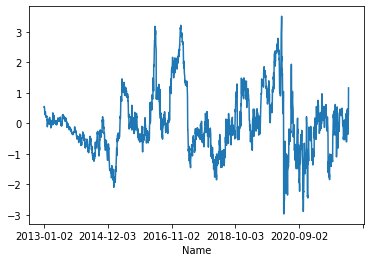

In [189]:
p1, p2 = pairs[8].split(' - ')[0], pairs[8].split(' - ')[1]
S1, S2 = equities_Finland_obx[p1], equities_Finland_obx[p2]

### Spread / Ratio
s_t = calc_spread(S1, S2, p1, p2)
ratio = S1 / S2

### z-scores
spread_z = (s_t - s_t.mean()) / s_t.std()
ratio_z = (ratio - ratio.mean()) / ratio.std()

spread_z.plot()
plt.show()

<AxesSubplot:xlabel='Name'>

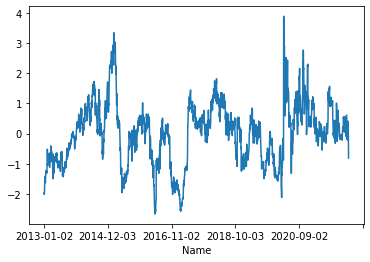

In [190]:
ratio_z.plot()

In [191]:
Finland_data = pd.concat([df, spread_z['2013-01-03':]], axis=1)
Finland_data.rename(columns={0:'Spread'}, inplace=True)
Finland_data.drop('Natural Gas - Henry Hub', axis=1, inplace=True)
Finland_data.isnull().sum()

WTI Crude Oil        0
Gold Bullion         0
Brent Europe         0
Copper               0
Aluminium            0
Baltic Dry Index     0
Natural Gas - RFV    0
Fish Pool Spot       0
Silver               0
VLCC                 0
10Y NO               0
10Y US               0
10Y UK               0
Spread               0
dtype: int64

#### Train test split

In [237]:
train, test, split = TS_train_test_split(Finland_data, 0.9)

y_train, y_test = train['Spread'], test['Spread']
X_train, X_test = train.drop('Spread', axis=1), test.drop('Spread', axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2150, 13)
(2150,)
(239, 13)
(239,)


#### Instantiating model

In [251]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

#### Coefficients / Betas

In [252]:
coefs = model.coef_

weights = dict(zip(Finland_data.columns, np.round(coefs, 3)))
weights_df = pd.DataFrame(weights.values(), index=weights.keys(), columns=['Betas'])
weights_df.sort_values(by='Betas', inplace=True, ascending=False)
weights_df

,Betas
Gold Bullion,8.019
Baltic Dry Index,2.131
Fish Pool Spot,0.728
Aluminium,0.653
WTI Crude Oil,0.486
VLCC,0.376
10Y NO,0.040
10Y UK,0.025
10Y US,-0.069
Copper,-0.285


In [253]:
model.score(X_test, y_test)

-0.06421037929835594

In [254]:
y_pred = model.predict(X_test)
# model.score(X_test,y_test)

In [255]:
model.intercept_

0.0

In [256]:
### Manually checking the predictions are correct

pred_calc = model.intercept_ + sum((X_test.iloc[10, :] * model.coef_))
pred = y_pred[10]
pred_calc == pred

True

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x21b8f559790>], [Text(0, 0, '')])

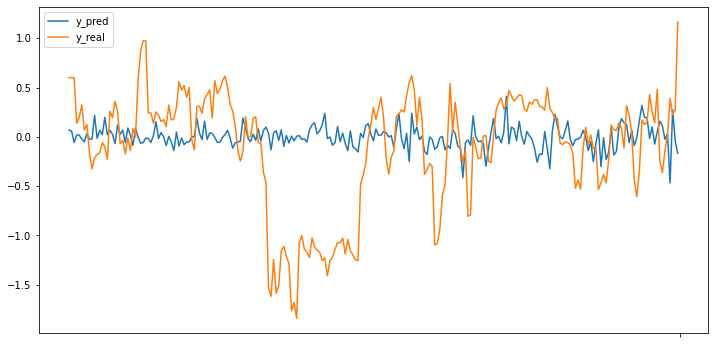

In [257]:
plt.figure(figsize=(12,6))
plt.plot(y_pred, label='y_pred')
plt.plot(y_test, label='y_real')
plt.legend()
plt.xticks('')

In [214]:
y_test

2021-04-01    0.600979
2021-04-02    0.600979
2021-04-05    0.600979
2021-04-06    0.137814
2021-04-07    0.198886
                ...   
2022-02-23    0.011667
2022-02-24    0.389212
2022-02-25    0.225928
2022-02-28    0.272545
2022-03-01    1.165445
Name: Spread, Length: 239, dtype: float64

In [260]:
equities_Finland_obx.columns = equities_Finland_obx.columns.str.replace('Finland', '')
pairs = list(Finland_pairs.keys())

p1, p2 = pairs[8].split(' - ')[0], pairs[8].split(' - ')[1]
S1, S2 = equities_Finland_obx[p1], equities_Finland_obx[p2]



In [264]:
help(MULTIVARIATE_REGRESSION)

Help on function MULTIVARIATE_REGRESSION in module __main__:

MULTIVARIATE_REGRESSION(equity_data: pandas.core.frame.DataFrame, factor_return: pandas.core.frame.DataFrame, pair: list, lag: int, tt_split: float = 0.9, spread=True)
    Performing multivariate regression
    and returning the pairs with corresponding coefficient



### Single

In [335]:
data = equities_Finland_obx
factors = df.drop('Natural Gas - Henry Hub', axis=1)
pair = Finland_pairs_list[2]

MULTIVARIATE_REGRESSION(data, factors, pair)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,WTI Crude Oil,Gold Bullion,Brent Europe,Copper,Aluminium,Baltic Dry Index,Natural Gas - RFV,Fish Pool Spot,Silver,VLCC,10Y NO,10Y US,10Y UK
UPM-KYMMENE - BAKKAFROST,0.167,-1.338,-0.555,-2.237,0.998,1.261,-0.3,0.272,3.603,0.083,-0.026,-0.112,0.023


### Multiple

In [334]:
MULTIVARIATE_REGRESSION_MULT(Finland_pairs_list, data, factors)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,WTI Crude Oil,Gold Bullion,Brent Europe,Copper,Aluminium,Baltic Dry Index,Natural Gas - RFV,Fish Pool Spot,Silver,VLCC,10Y NO,10Y US,10Y UK
KONE 'B' - NEL,0.117,-6.560,-0.271,1.433,-0.151,2.197,-0.032,0.309,3.041,-0.009,0.045,0.033,-0.034
NESTE - NEL,-0.202,-6.334,0.100,1.158,0.828,2.049,0.298,-0.062,4.451,-0.424,0.043,0.077,-0.046
UPM-KYMMENE - BAKKAFROST,0.167,-1.338,-0.555,-2.237,0.998,1.261,-0.300,0.272,3.603,0.083,-0.026,-0.112,0.023
STORA ENSO R - STOREBRAND,0.588,6.545,-1.273,0.022,-0.292,-0.177,-0.585,0.027,-3.414,-0.196,0.022,-0.119,0.056
ELISA - BAKKAFROST,1.281,1.423,-2.393,0.755,0.592,-0.647,0.245,1.053,-2.617,0.464,0.171,0.065,-0.065
KONECRANES - ATEA,-0.502,-1.778,0.609,-0.672,-1.814,-0.423,-0.457,0.627,3.665,0.324,-0.084,-0.128,0.047
KEMIRA - BAKKAFROST,-0.614,2.804,0.107,-0.376,-1.007,1.102,-0.334,0.158,-0.813,0.352,-0.095,-0.018,0.002
TIETOEVRY - ORKLA,-1.417,2.003,2.458,1.588,0.166,1.346,0.255,0.010,-0.020,0.070,-0.042,0.052,0.006
TIETOEVRY - EIENDOMSSPAR,0.486,8.019,-0.856,-0.285,0.653,2.131,-0.912,0.728,-4.511,0.376,0.040,-0.069,0.025
FISKARS 'A' - YARA INTERNATIONAL,-0.357,-1.130,0.301,0.790,-1.827,-0.175,0.353,-0.476,2.342,0.445,-0.013,-0.034,0.058


### Norwegian equities factorcorrelation

In [338]:
equities_obx.columns

Index(['EQUINOR', 'DNB BANK', 'TELENOR', 'NORSK HYDRO', 'AKER BP', 'MOWI',
       'YARA INTERNATIONAL', 'AKER', 'DNO', 'GJENSIDIGE FORSIKRING',
       'GRIEG SEAFOOD', 'ORKLA', 'SALMAR', 'SCHIBSTED A', 'TOMRA SYSTEMS',
       'AF GRUPPEN 'A'', 'ARENDALS FOSSEKOMPANI', 'ATEA', 'AUSTEVOLL SEAFOOD',
       'BAKKAFROST', 'BONHEUR', 'BORREGAARD', 'EIENDOMSSPAR', 'FRONTLINE',
       'GOLAR LNG (NAS)', 'KONGSBERG GRUPPEN', 'LEROY SEAFOOD GROUP', 'NEL',
       'NORDIC SEMICONDUCTOR', 'NORWAY ROYAL SALMON', 'NORWEGIAN AIR SHUTTLE',
       'PROTECTOR FORSIKRING', 'STOREBRAND', 'SUBSEA 7', 'VEIDEKKE',
       'WALLENIUS WILHELMSEN'],
      dtype='object')

In [397]:
df.columns

Index(['WTI Crude Oil', 'Gold Bullion', 'Brent Europe', 'Copper', 'Aluminium',
       'Baltic Dry Index', 'Natural Gas - RFV', 'Natural Gas - Henry Hub',
       'Fish Pool Spot', 'Silver', 'VLCC', '10Y NO', '10Y US', '10Y UK'],
      dtype='object')

In [12]:
eq = equities_obx['EQUINOR']

df_corr = FACTOR_CORRELATIONS(eq, df)
df_corr

,EQUINOR,relative_weight,EQUINOR binned
Brent Europe,0.39,2.95,High
Copper,0.26,1.97,High
10Y US,0.21,1.59,High
10Y NO,0.20,1.51,High
10Y UK,0.19,1.44,Medium
Aluminium,0.16,1.21,Medium
WTI Crude Oil,0.14,1.06,Medium
Natural Gas - RFV,0.14,1.06,Medium
Silver,0.11,0.83,Medium
Natural Gas - Henry Hub,0.03,0.23,Medium


In [13]:
df_corr[['relative_weight']].style.format().background_gradient()

,relative_weight
Brent Europe,2.950000
Copper,1.970000
10Y US,1.590000
10Y NO,1.510000
10Y UK,1.440000
Aluminium,1.210000
WTI Crude Oil,1.060000
Natural Gas - RFV,1.060000
Silver,0.830000
Natural Gas - Henry Hub,0.230000


In [14]:
df_corr[['EQUINOR']].T
df_corr[['EQUINOR binned']].T

,Brent Europe,Copper,10Y US,10Y NO,10Y UK,Aluminium,WTI Crude Oil,Natural Gas - RFV,Silver,Natural Gas - Henry Hub,Baltic Dry Index,Gold Bullion,Fish Pool Spot,VLCC
EQUINOR binned,High,High,High,High,Medium,Medium,Medium,Medium,Medium,Medium,Low,Low,Low,Low


### Multiple equities (equities for enire country)

In [43]:
a = FACTOR_CORRELATIONS_MULTIPLE_EQT(equities_obx, df)
a.index = [i.replace(' binned', '') for i in a.index]
a.head()

,Brent Europe,Copper,10Y US,10Y NO,10Y UK,Aluminium,WTI Crude Oil,Natural Gas - RFV,Silver,Natural Gas - Henry Hub,Baltic Dry Index,Gold Bullion,Fish Pool Spot,VLCC
EQUINOR,Very High,Very High,High,High,Medium,Medium,Medium,Medium,Medium,Medium,Low,Low,Low,Low
DNB BANK,High,Medium,Very High,Very High,High,Medium,Medium,Low,Medium,Medium,Medium,Low,Low,Low
TELENOR,Very High,Medium,Very High,High,High,Medium,Medium,Low,Medium,Low,Medium,Low,Medium,Low
NORSK HYDRO,High,Very High,Medium,High,Medium,Very High,Medium,Medium,Medium,Low,Low,Low,Medium,Low
AKER BP,Very High,Very High,High,High,Medium,Medium,Medium,Medium,Medium,Medium,Low,Low,Low,Low


In [29]:
a.loc['FRONTLINE',:]

Brent Europe                  Medium
Copper                          High
10Y US                     Very High
10Y NO                        Medium
10Y UK                          High
Aluminium                     Medium
WTI Crude Oil                    Low
Natural Gas - RFV             Medium
Silver                        Medium
Natural Gas - Henry Hub          Low
Baltic Dry Index              Medium
Gold Bullion                     Low
Fish Pool Spot                   Low
VLCC                       Very High
Name: FRONTLINE, dtype: object

### Using data of different time-intervals to detect correlation
> Many things can have changed fundamentally over the last 10 years

#### Comparing correlations
* ***quantiles*** = False -> custom set boundaries for magnifying relative correlations
* ***quantiles*** = True -> eqt quantiles used for magnifying relative correlations

Set ***quantiles*** to False, to get the best comparison between equities

In [111]:
obx_corr_compare = COMPARE_EQT_CORRELATIONS_TIME(equities_obx, df, '2021-01-02', quantiles=False)
obx_corr_compare['EQUINOR'].sort_values(by='2021--> correlation',ascending=False)

,10-year correlation,2021--> correlation,10-year correlation BINNED,2021--> correlation BINNED
Natural Gas - RFV,0.14,0.38,Low,Very High
Brent Europe,0.39,0.35,Very High,Very High
WTI Crude Oil,0.14,0.34,Low,Very High
Aluminium,0.16,0.27,Medium,High
Copper,0.26,0.25,High,Medium
10Y US,0.21,0.21,Medium,Medium
10Y NO,0.20,0.17,Medium,Medium
Silver,0.11,0.17,Low,Medium
10Y UK,0.19,0.09,Medium,Low
Gold Bullion,-0.00,0.08,Low,Low


>Pay attention to the correlations of Equinor to the Natural Gas - RFV. The correlation is "Medium" for all timeintervals >starting from 2012 to 2020, but when the correlation is calculated, starting form 2021, the correlation is set to "Very High". >This means theat currently, Equinor has a Very high correlation with the natural Gas - RFV. This would not be detected using a >longer time interval, and showecases the importance of using shorter (more recent) time intervals when calculating the >correlation to the different factors

## Rolling Correlations

In [8]:
equities_obx_returns = equities_obx.pct_change()

In [222]:
# plt.figure(figsize=(12,50))
# plt.subplots_adjust(top=1.25, bottom=1.2)

# rows = int(np.ceil(len(df.columns)/2))
# cols = len(df.columns)//2

# lookback = 200

# for i, c in enumerate(df.columns, start=1):
#     F = df[c]
#     plt.subplot(7, 2, i)
#     S.rolling(lookback).corr(F)[lookback:].plot()
#     plt.ylabel(None)
#     plt.xlabel(None)
#     plt.title(f'{c}')
#     plt.grid(True, axis='y')
    
# plt.tight_layout()


### Equity in Focus

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

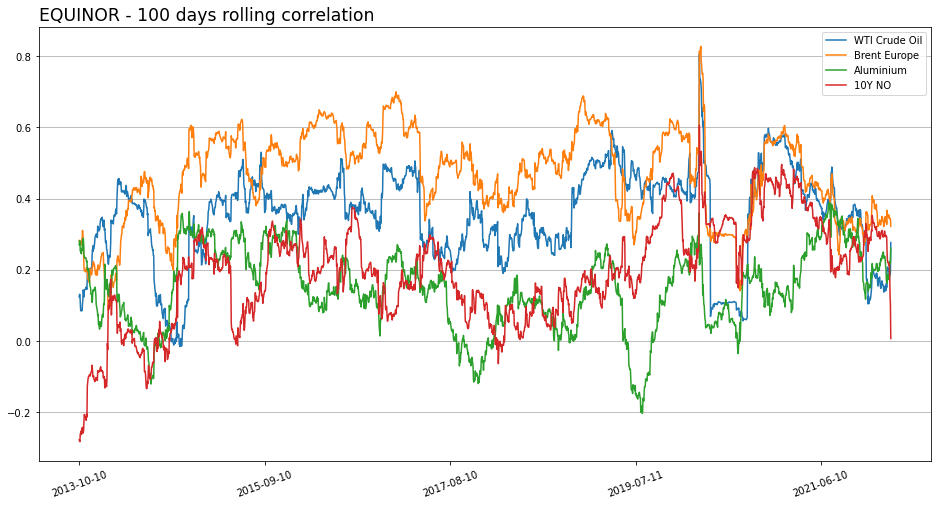

In [11]:
cols = ['WTI Crude Oil', 'Brent Europe', 'Aluminium',
        '10Y NO']
window = 100
eqt = 'EQUINOR'
S = equities_obx_returns[eqt]

S.rolling(window).corr(df[cols])[200:].plot(figsize=(16,8))
plt.title(f'{eqt} - {window} days rolling correlation', loc='left', size='xx-large')
plt.xlabel('')
plt.grid(True, axis='y')
plt.xticks(rotation=20)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

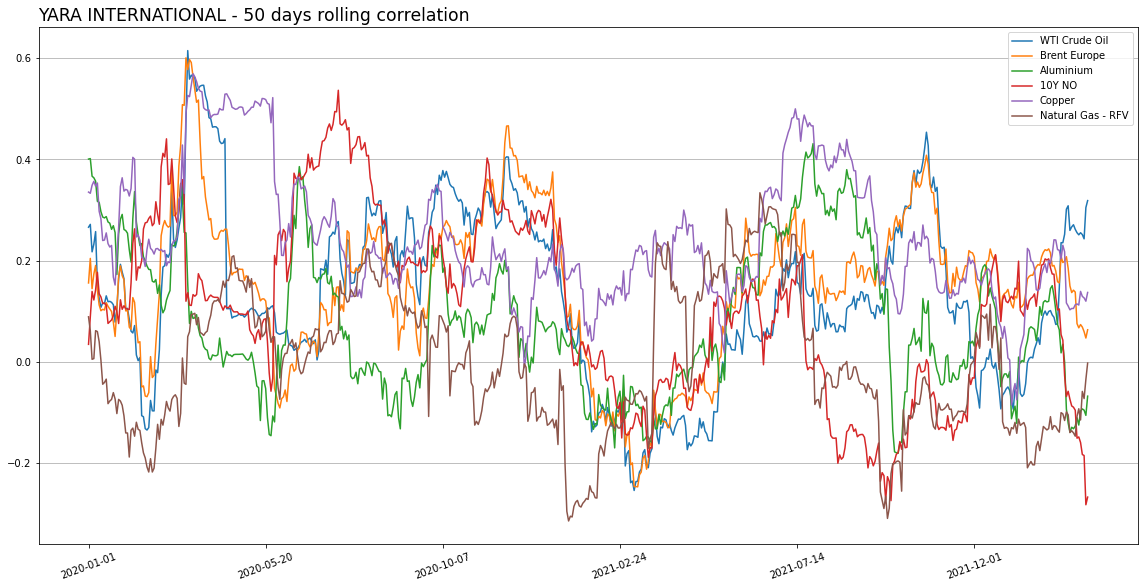

In [12]:
cols = ['WTI Crude Oil', 'Brent Europe', 'Aluminium',
        '10Y NO', 'Copper', 'Natural Gas - RFV']
window = 50
eqt = 'YARA INTERNATIONAL'
S = equities_obx_returns[eqt]

S.rolling(window).corr(df[cols])['2020-01-01':].plot(figsize=(16,8))
plt.title(f'{eqt} - {window} days rolling correlation', loc='left', size='xx-large')
plt.xlabel('')
plt.grid(True, axis='y')
plt.tight_layout()
plt.xticks(rotation=20)
plt.show()

### Factor in Focus

In [9]:
FR = df['Brent Europe'][:'2019-06']
eqt_lim = 6
equities_obx_returns.iloc[:,:4]

,EQUINOR,DNB BANK,TELENOR,NORSK HYDRO
Name,,,,
2013-01-02,NaN,NaN,NaN,NaN
2013-01-03,-0.000710,0.000000,0.006184,0.005877
2013-01-04,0.003521,0.013891,0.006146,-0.009969
2013-01-07,-0.008433,0.000000,-0.002622,-0.008681
2013-01-08,-0.000714,0.002052,0.005257,-0.003152
...,...,...,...,...
2022-02-23,0.022827,-0.000966,0.001857,0.019663
2022-02-24,0.041922,-0.070358,-0.047173,0.032557
2022-02-25,-0.054406,0.029909,0.019097,0.012369


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

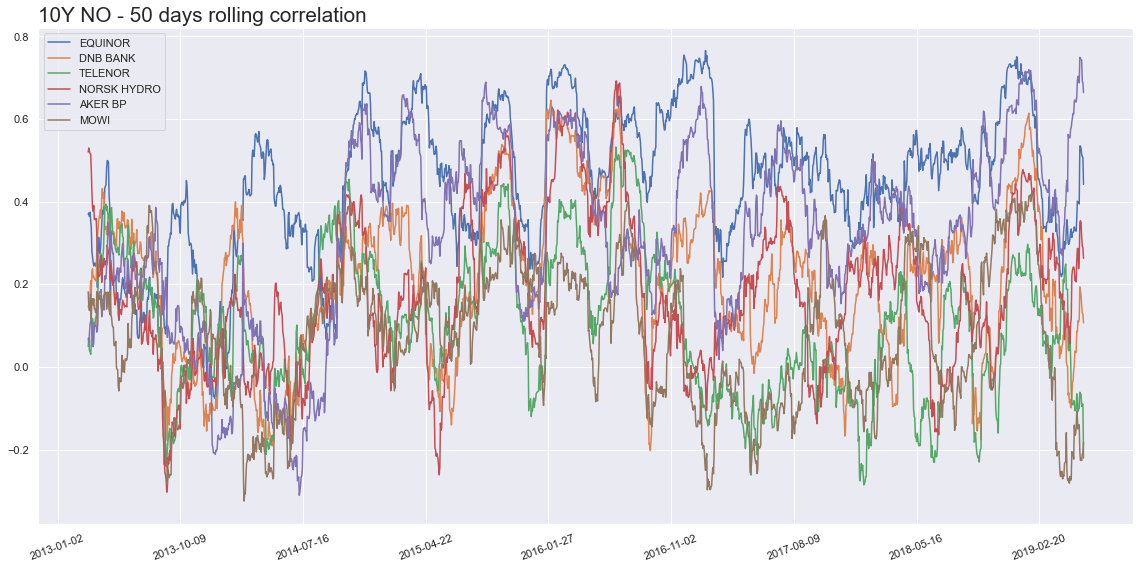

In [156]:
FR.rolling(window).corr(equities_obx_returns.iloc[:,:eqt_lim])[:'2019-06-01'].plot(figsize=(16,8))
plt.title(f'10Y NO - {window} days rolling correlation', loc='left', size='xx-large')
plt.tight_layout()
plt.xlabel('')
plt.grid(True, axis='y')
plt.xticks(rotation=20)
plt.show()

In [34]:
brent = pd.read_excel('MASTER_A.xlsx', sheet_name='Factors', index_col='Date')['Europe Brent Spot FOB U$/BBL Daily'][1:]
brent

Date
2012-03-01    125.76
2012-03-02    125.93
2012-03-05    126.68
2012-03-06    125.03
2012-03-07    125.37
               ...  
2022-02-23     98.73
2022-02-24     98.73
2022-02-25     98.73
2022-02-28     98.73
2022-03-01     98.73
Name: Europe Brent Spot FOB U$/BBL Daily, Length: 2609, dtype: object

In [46]:
nok_eur = pd.read_excel('MASTER_A.xlsx', sheet_name='Currency',
                        usecols=['Date', 'NOK - EUR'], index_col='Date')
df_NOK_brent = pd.concat([nok_eur, brent], axis=1)
df_NOK_brent.columns = ['NOK-EUR', 'Brent']

In [89]:
from plotly.subplots import make_subplots
num_eqt = 3
window = 50
FR = df['10Y NO'][:'2019-06']
FR_2 = osebx_returns[:'2019-06']

c_1 = '#4d79ff'
c_2 = '#ff6666'
c_3 = '#99b3ff'
c_4 = '#ff6699'

colors = [c_1, c_2, c_3, c_4]
EQT = ['MOWI', 'BAKKAFROST', 'SALMAR']

start = '2013-03-01'
end = '2022-01-01'

fig = make_subplots(specs=[[{"secondary_y": True}]])

SALMAR = FR.rolling(window).corr(equities_obx_returns['SALMAR'])[:'2019-06-01']
MOWI = FR.rolling(window).corr(equities_obx_returns['MOWI'])[:'2019-06-01']
BAKKAFROST = FR.rolling(window).corr(equities_obx_returns['BAKKAFROST'])[:'2019-06-01']

BRENT = FR_2.rolling(window).corr(df2['Brent Europe'])[start:end]
NO_10Y = FR_2.rolling(window).corr(df2['10Y NO'])[start:end]
NOK_EUR = FR_2.rolling(window).corr(df2['NOK - EUR'])[start:end]
# NOK_USD = FR_2.rolling(window).corr(df2['NOK - USD'])[:'2019-06-01']



### 1
fig.add_scatter(x = df_NOK_brent['Brent'][start:end].index,
                y = df_NOK_brent['Brent'][start:end],
                name = 'Brent Europe<br>Spot',
                line = dict(color=c_4, width=2.5, dash='solid')
               )

### 3
# fig.add_scatter(x = COPPER.index,
#                 y = COPPER,
#                 name = 'COPPER',
#                 line = dict(color=c_2, width=2, dash='solid')
#                )

### 1
fig.add_scatter(x = df_NOK_brent['NOK-EUR'][start:end].index,
                y = 1/df_NOK_brent['NOK-EUR'][start:end],
                name = 'NOK / EUR',
                secondary_y=True,
                line = dict(color=c_3, width=2, dash='solid')
               )

# ### 4
# fig.add_scatter(x = NOK_EUR.index,
#                 y = NOK_EUR,
#                 name = 'NOK - EUR',
#                 line = dict(color=c_3, width=2, dash='solid')
#                )

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,        # hide grid x-lines
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
#         title= '',
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)'
        ),
        
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True
    ),
#     autosize=False,
#     margin=dict(
#         autoexpand=False,
#         ### size specifics
#         l = 100,           # left margin  --> in px, default = 80 
#         r = 200,            # right margin --> in px, default = 80
#         t = 110,           # top margin   --> in px, default = 100
#         b = 80,            # bottom margin--> in px, default = 80
#     ),
    showlegend=True,
    plot_bgcolor='white'

)
# fig.add_hline(y=0, line_width=0.5, line_dash="dot", line_color="rgb(82, 82, 82)")
fig.update_traces(textposition="bottom right")
fig.update_layout(height=600, width=1000,
                  legend = {'title': 'Price series'})
fig.update_yaxes(title='NOK / EUR', secondary_y=True)
fig.update_yaxes(title='Brent Europe spot', secondary_y=False)
fig.show()
    

In [27]:
df2.columns

Index(['WTI Crude Oil', 'Gold Bullion', 'Brent Europe', 'Copper', 'Aluminium',
       'Baltic Dry Index', 'Natural Gas - RFV', 'Natural Gas - Henry Hub',
       'Fish Pool Spot', 'Silver', 'VLCC', '10Y NO', '10Y US', '10Y UK',
       'NOK - USD', 'NOK - EUR', 'NOK - £'],
      dtype='object')

In [276]:
num_eqt = 3
window = 20
FR = df['Brent Europe'][:'2019-06']

c_1 = '#4d79ff'
c_2 = '#ff6666'
c_3 = '#00cc99'
c_4 = '#ac00e6'

fig = go.Figure()

EQUINOR = FR.rolling(window).corr(equities_obx_returns['EQUINOR'])[:'2019-06-01']
DNB_BANK = FR.rolling(window).corr(equities_obx_returns['DNB BANK'])[:'2019-06-01']
TELENOR = FR.rolling(window).corr(equities_obx_returns['TELENOR'])[:'2019-06-01']

### 1
fig.add_scatter(x = EQUINOR.index,
                y = EQUINOR,
                name = 'EQUINOR',
                line = dict(color=c_1, width=2, dash='solid')
               )

### 2
fig.add_scatter(x = DNB_BANK.index,
                y = DNB_BANK,
                name = 'DNB BANK',
                line = dict(color=c_2, width=2, dash='solid')
               )
### 3
fig.add_scatter(x = TELENOR.index,
                y = TELENOR,
                name = 'TELENOR',
                line = dict(color=c_3, width=2, dash='solid')
               )

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,        # hide grid x-lines
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)'
        ),
        
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True
    ),
#     autosize=False,
#     margin=dict(
#         autoexpand=False,
#         ### size specifics
#         l = 100,           # left margin  --> in px, default = 80 
#         r = 200,            # right margin --> in px, default = 80
#         t = 110,           # top margin   --> in px, default = 100
#         b = 80,            # bottom margin--> in px, default = 80
#     ),
    showlegend=True,
    plot_bgcolor='white'

)
fig.add_hline(y=0, line_width=0.5, line_dash="dot", line_color="rgb(82, 82, 82)")
fig.update_traces(textposition="bottom right")
fig.update_layout(height=600, width=1000,
                  legend = {'title': 'Norwegian equity'})
fig.show()
    

<IPython.core.display.Javascript object>

In [190]:
px.line(df['Brent Europe'].cumsum())

In [142]:
px.colors.diverging.swatches() #cmocean, colorbrewer, cyclical, qualitative, diverging

In [92]:
px.colors.sequential.swatches()

In [36]:
import plotly.express as px

In [152]:
fig = px.imshow(df2[:'2019-06'].corr(), color_continuous_scale='RdBu', color_continuous_midpoint=0)
fig.update_layout(height=650,
                  margin=dict(
                    autoexpand=False,
                    ### size specifics
                    l = 200, 
                    r = 300,
#                     t = 110,
                    b = 80))
fig.write_image('name.png', height=650)
fig.show()

In [151]:
df2[:'2019-06']

,WTI Crude Oil,Gold Bullion,Brent Europe,Copper,Aluminium,Baltic Dry Index,Natural Gas - RFV,Natural Gas - Henry Hub,Fish Pool Spot,Silver,VLCC,10Y NO,10Y US,10Y UK,NOK - USD,NOK - EUR,NOK - £
Date,,,,,,,,,,,,,,,,,
2013-01-03,-0.002148,-0.006260,0.000443,-0.005743,-0.021037,0.002865,0.013462,NaN,0.000000,-0.005803,0.000000,0.0935,0.6460,0.7225,0.008626,-0.002345,0.000850
2013-01-04,0.001830,-0.019011,-0.003981,-0.010017,-0.026531,0.008571,0.005693,NaN,-0.004618,-0.036965,0.000000,0.3315,-0.0680,0.3740,0.006695,0.002803,-0.000911
2013-01-07,0.001074,0.001481,-0.000799,-0.002173,0.000987,0.008499,0.016981,NaN,0.000000,0.008081,0.000000,-0.0170,-0.0170,-0.2635,-0.003004,0.001128,-0.000083
2013-01-08,-0.000429,0.002685,0.004800,0.000964,0.000986,0.030899,0.005566,NaN,0.000000,0.011022,0.000000,-0.1700,0.0000,-0.4760,0.002951,0.000423,0.000089
2013-01-09,-0.000537,0.002859,0.000354,0.000093,0.004554,0.012262,0.005535,NaN,0.000000,-0.002973,0.000000,-0.0935,-0.3485,-0.0510,-0.001400,-0.003159,-0.003208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27,0.000000,0.001301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.0850,0.0000,0.0000,0.000500,-0.000569,-0.000484
2019-05-28,0.012151,-0.005181,0.032510,0.001517,0.003953,0.015009,0.016260,-0.007692,0.000000,-0.015089,-0.022727,-0.1700,-0.5185,-0.3230,-0.001418,-0.003025,-0.001810
2019-05-29,-0.005580,0.002518,0.006411,-0.014644,-0.006609,0.023105,-0.060000,0.015504,0.000000,0.006964,-0.046512,-0.0850,-0.2720,-0.2125,0.007856,0.005015,0.004435


<IPython.core.display.Javascript object>

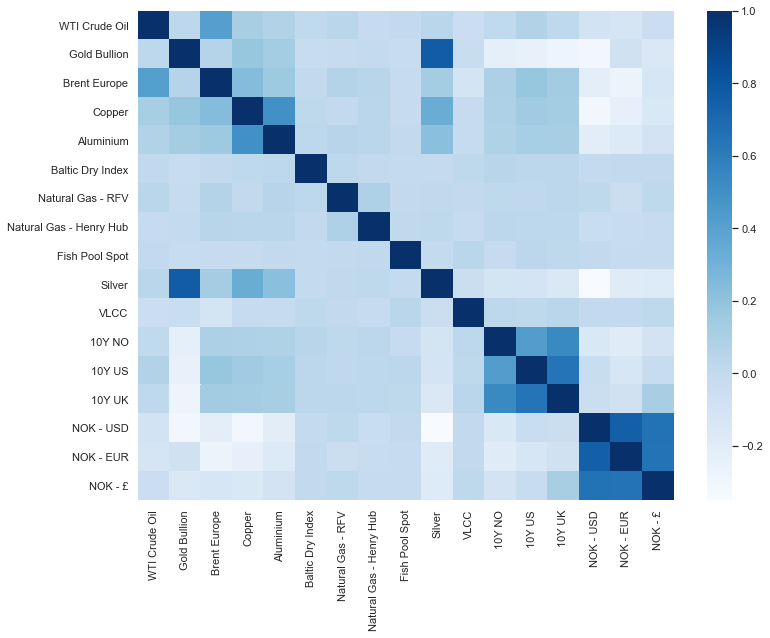

In [56]:
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(df2.corr(), cmap="Blues")
plt.show()

## Writing rolling factor correlations to excel

In [12]:
### OSEBX
osebx = pd.read_excel('MASTER_A.xlsx',
                      sheet_name = 'Indices2',
                      usecols=['Date', 'OSEBX'],
                      index_col = 'Date')
osebx = osebx[1:]
osebx_returns = osebx.pct_change()['2013':]
osebx_returns.index = osebx_returns.index.astype(str)
osebx_returns = osebx_returns.reindex(df2.index, axis='index')
osebx_returns = pd.Series(osebx_returns['OSEBX'])

In [311]:
osebx_corr_20 = EQT_FACTOR_CORRELATIONS(osebx_returns, df2, 20)
osebx_corr_20.head()

,WTI Crude Oil,Gold Bullion,Brent Europe,Copper,Aluminium,Baltic Dry Index,Natural Gas - RFV,Natural Gas - Henry Hub,Fish Pool Spot,Silver,VLCC,10Y NO,10Y US,10Y UK,NOK - USD,NOK - EUR,NOK - £
Date,,,,,,,,,,,,,,,,,
2013-01-31,0.088891,-0.006543,0.070319,-0.028497,-0.255769,0.504401,-0.273503,NaN,0.162876,0.067334,-0.296610,-0.218796,0.108522,0.021886,0.050894,-0.007809,-0.210990
2013-02-01,0.090266,0.114115,0.067152,0.195357,-0.062344,0.357909,-0.155250,NaN,-0.139077,0.227181,-0.213381,-0.383263,0.200465,-0.011779,-0.110113,-0.016095,-0.391690
2013-02-04,0.216051,0.120880,0.020994,0.161758,-0.020876,0.424372,-0.104800,NaN,-0.145185,0.275690,-0.210538,-0.371115,0.288598,-0.050941,-0.226685,0.049436,-0.443514
2013-02-05,0.200011,0.128088,-0.034095,0.194686,-0.013620,0.423742,-0.139210,NaN,-0.132910,0.272004,-0.241692,-0.370405,0.223034,-0.057626,-0.287719,0.035671,-0.463963
2013-02-06,0.224524,0.059569,0.022849,0.230081,0.024404,0.380066,-0.140855,NaN,-0.113772,0.294483,-0.262494,-0.292338,0.343709,0.010690,-0.278616,0.089990,-0.445851


In [312]:
### Reading to file
with pd.ExcelWriter('OSEBX_factor_corr_20_ALL.xlsx') as writer:
    osebx_corr_20.to_excel(writer, sheet_name='Sheet_1')

In [314]:
### Returns
obx_returns_100 = equities_obx_100.pct_change()[1:]
obx_returns_100

,EQUINOR,DNB BANK,MOWI,TELENOR,DNO,FRONTLINE,GAMING INNOVATION GROUP,GJENSIDIGE FORSIKRING,NORSK HYDRO,SCHIBSTED A,...,STRONGPOINT,SUBSEA 7,TECHSTEP,TGS,TOMRA SYSTEMS,TOTENS SPAREBANK,VEIDEKKE,VOSS VEKSEL- OG LANDMANDSBANK,WALLENIUS WILHELMSEN,WILSON
Name,,,,,,,,,,,,,,,,,,,,,
2013-01-03,-0.000710,0.000000,-0.005650,0.006184,-0.002077,0.026445,-0.019920,0.000000,0.005877,0.003313,...,0.042278,-0.002940,-0.070632,-0.018570,-0.028973,0.022214,-0.008949,0.000000,-0.004955,0.000000
2013-01-04,0.003521,0.013891,-0.011364,0.006146,0.004163,0.061840,0.000000,-0.007329,-0.009969,0.002895,...,0.023447,0.014741,0.012000,-0.012431,-0.006956,0.017412,0.004514,-0.012823,0.009918,0.000000
2013-01-07,-0.008433,0.000000,-0.014368,-0.002622,-0.012956,-0.033976,0.000000,-0.004922,-0.008681,-0.002060,...,0.010309,-0.014527,0.063241,-0.012587,0.002001,0.025638,0.002248,0.000000,0.000000,0.000000
2013-01-08,-0.000714,0.002052,0.002915,0.005257,0.021527,-0.005007,0.000000,0.009258,-0.003152,0.000000,...,-0.014512,-0.000727,-0.048327,0.069840,-0.020000,0.010396,0.002243,0.028572,0.014710,0.000000
2013-01-09,0.008540,0.000686,0.011628,0.008682,-0.009252,0.000000,0.037940,-0.001194,0.004568,0.005363,...,-0.052232,0.002950,0.000000,0.018137,-0.030626,-0.008225,0.002236,0.000000,0.014497,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-23,0.022827,-0.000966,0.030650,0.001857,-0.015437,0.009621,-0.011628,0.014210,0.019663,0.003019,...,0.024795,0.000986,0.000000,-0.002707,-0.037949,0.016526,0.010786,0.008696,-0.016040,0.048181
2022-02-24,0.041922,-0.070358,-0.043616,-0.047173,0.027188,0.023594,-0.037647,-0.022890,0.032557,-0.012043,...,-0.048391,-0.031520,0.000000,-0.005187,-0.025320,-0.024389,-0.021342,-0.008621,-0.038522,-0.149424
2022-02-25,-0.054406,0.029909,0.041874,0.019097,-0.007611,0.010099,0.058680,0.033458,0.012369,0.063126,...,0.008485,0.020777,-0.018265,0.020052,0.050212,0.016668,0.007788,0.000000,0.033138,0.175674


In [316]:
### 10-day rolling window
with pd.ExcelWriter('NO_factor_correlations_10_ALL.xlsx') as writer:

    for number, eqt in enumerate(obx_returns_100.columns, start=1):    

        correlations = EQT_FACTOR_CORRELATIONS(obx_returns_100[eqt], df2, 10)
        correlations.fillna(method='bfill', limit=3, inplace=True)
        
        eqt = eqt.replace("'A'", 'A')
        eqt = eqt.replace("'B'", 'B')

        correlations.to_excel(writer, sheet_name=eqt[:30])
        print('10 ', eqt)

10  EQUINOR
10  DNB BANK
10  MOWI
10  TELENOR
10  DNO
10  FRONTLINE
10  GAMING INNOVATION GROUP
10  GJENSIDIGE FORSIKRING
10  NORSK HYDRO
10  SCHIBSTED A
10  STOREBRAND
10  YARA INTERNATIONAL
10  ABG SUNDAL COLLIER HOLDING
10  AEGA
10  AF GRUPPEN A
10  AKASTOR
10  AKER
10  AKER BP
10  AKVA GROUP
10  ARCHER
10  ARCTICZYMES TECHNOLOGIES
10  ARENDALS FOSSEKOMPANI
10  ATEA
10  AUSTEVOLL SEAFOOD
10  AWILCO DRILLING
10  AWILCO LNG
10  AXACTOR
10  BAKKAFROST
10  BELSHIPS
10  BONHEUR
10  BORGESTAD A
10  BORREGAARD
10  BOUVET
10  BW OFFSHORE
10  BYGGMA
10  CARASENT
10  CONTEXTVISION
10  DOF
10  EIDESVIK OFFSHORE
10  ELECTROMAG.GEOSVS.
10  ENDUR
10  ENSURGE MICROPOWER
10  FLEX LNG
10  GC RIEBER SHIPPING
10  GRIEG SEAFOOD
10  HAVILA SHIPPING
10  HEXAGON COMPOSITES
10  HUNTER GROUP
10  IDEX BIOMETRICS
10  INTEROIL EXP.&. PRDN.
10  ITERA
10  JINHUI SHIPPING AND TRANSPORTATION
10  KITRON
10  KMC PROPERTIES
10  KONGSBERG GRUPPEN
10  LEROY SEAFOOD GROUP
10  MAGNORA
10  MEDI-STIM
10  NAVAMEDIC
10  NEKK

In [319]:
### 15-day rolling window
with pd.ExcelWriter('NO_factor_correlations_15_ALL.xlsx') as writer:

    for number, eqt in enumerate(obx_returns_100.columns, start=1):    

        correlations = EQT_FACTOR_CORRELATIONS(obx_returns_100[eqt], df2, 15)
        correlations.fillna(method='bfill', limit=3, inplace=True)
        
        eqt = eqt.replace("'A'", 'A')
        eqt = eqt.replace("'B'", 'B')

        correlations.to_excel(writer, sheet_name=eqt[:30])
        print('15 ', eqt)

15  EQUINOR
15  DNB BANK
15  MOWI
15  TELENOR
15  DNO
15  FRONTLINE
15  GAMING INNOVATION GROUP
15  GJENSIDIGE FORSIKRING
15  NORSK HYDRO
15  SCHIBSTED A
15  STOREBRAND
15  YARA INTERNATIONAL
15  ABG SUNDAL COLLIER HOLDING
15  AEGA
15  AF GRUPPEN A
15  AKASTOR
15  AKER
15  AKER BP
15  AKVA GROUP
15  ARCHER
15  ARCTICZYMES TECHNOLOGIES
15  ARENDALS FOSSEKOMPANI
15  ATEA
15  AUSTEVOLL SEAFOOD
15  AWILCO DRILLING
15  AWILCO LNG
15  AXACTOR
15  BAKKAFROST
15  BELSHIPS
15  BONHEUR
15  BORGESTAD A
15  BORREGAARD
15  BOUVET
15  BW OFFSHORE
15  BYGGMA
15  CARASENT
15  CONTEXTVISION
15  DOF
15  EIDESVIK OFFSHORE
15  ELECTROMAG.GEOSVS.
15  ENDUR
15  ENSURGE MICROPOWER
15  FLEX LNG
15  GC RIEBER SHIPPING
15  GRIEG SEAFOOD
15  HAVILA SHIPPING
15  HEXAGON COMPOSITES
15  HUNTER GROUP
15  IDEX BIOMETRICS
15  INTEROIL EXP.&. PRDN.
15  ITERA
15  JINHUI SHIPPING AND TRANSPORTATION
15  KITRON
15  KMC PROPERTIES
15  KONGSBERG GRUPPEN
15  LEROY SEAFOOD GROUP
15  MAGNORA
15  MEDI-STIM
15  NAVAMEDIC
15  NEKK

In [321]:
### 20-day rolling window
with pd.ExcelWriter('NO_factor_correlations_20_ALL.xlsx') as writer:

    for number, eqt in enumerate(obx_returns_100.columns, start=1):    

        correlations = EQT_FACTOR_CORRELATIONS(obx_returns_100[eqt], df2, 20)
        correlations.fillna(method='bfill', limit=3, inplace=True)
        
        eqt = eqt.replace("'A'", 'A')
        eqt = eqt.replace("'B'", 'B')

        correlations.to_excel(writer, sheet_name=eqt[:30])
        print('20 ', eqt)

20  EQUINOR
20  DNB BANK
20  MOWI
20  TELENOR
20  DNO
20  FRONTLINE
20  GAMING INNOVATION GROUP
20  GJENSIDIGE FORSIKRING
20  NORSK HYDRO
20  SCHIBSTED A
20  STOREBRAND
20  YARA INTERNATIONAL
20  ABG SUNDAL COLLIER HOLDING
20  AEGA
20  AF GRUPPEN A
20  AKASTOR
20  AKER
20  AKER BP
20  AKVA GROUP
20  ARCHER
20  ARCTICZYMES TECHNOLOGIES
20  ARENDALS FOSSEKOMPANI
20  ATEA
20  AUSTEVOLL SEAFOOD
20  AWILCO DRILLING
20  AWILCO LNG
20  AXACTOR
20  BAKKAFROST
20  BELSHIPS
20  BONHEUR
20  BORGESTAD A
20  BORREGAARD
20  BOUVET
20  BW OFFSHORE
20  BYGGMA
20  CARASENT
20  CONTEXTVISION
20  DOF
20  EIDESVIK OFFSHORE
20  ELECTROMAG.GEOSVS.
20  ENDUR
20  ENSURGE MICROPOWER
20  FLEX LNG
20  GC RIEBER SHIPPING
20  GRIEG SEAFOOD
20  HAVILA SHIPPING
20  HEXAGON COMPOSITES
20  HUNTER GROUP
20  IDEX BIOMETRICS
20  INTEROIL EXP.&. PRDN.
20  ITERA
20  JINHUI SHIPPING AND TRANSPORTATION
20  KITRON
20  KMC PROPERTIES
20  KONGSBERG GRUPPEN
20  LEROY SEAFOOD GROUP
20  MAGNORA
20  MEDI-STIM
20  NAVAMEDIC
20  NEKK

In [323]:
### 50-day rolling window
with pd.ExcelWriter('NO_factor_correlations_50_ALL.xlsx') as writer:

    for number, eqt in enumerate(obx_returns_100.columns, start=1):    

        correlations = EQT_FACTOR_CORRELATIONS(obx_returns_100[eqt], df2, 50)
        correlations.fillna(method='bfill', limit=3, inplace=True)
        
        eqt = eqt.replace("'A'", 'A')
        eqt = eqt.replace("'B'", 'B')

        correlations.to_excel(writer, sheet_name=eqt[:30])
        print('50 ', eqt)

50  EQUINOR
50  DNB BANK
50  MOWI
50  TELENOR
50  DNO
50  FRONTLINE
50  GAMING INNOVATION GROUP
50  GJENSIDIGE FORSIKRING
50  NORSK HYDRO
50  SCHIBSTED A
50  STOREBRAND
50  YARA INTERNATIONAL
50  ABG SUNDAL COLLIER HOLDING
50  AEGA
50  AF GRUPPEN A
50  AKASTOR
50  AKER
50  AKER BP
50  AKVA GROUP
50  ARCHER
50  ARCTICZYMES TECHNOLOGIES
50  ARENDALS FOSSEKOMPANI
50  ATEA
50  AUSTEVOLL SEAFOOD
50  AWILCO DRILLING
50  AWILCO LNG
50  AXACTOR
50  BAKKAFROST
50  BELSHIPS
50  BONHEUR
50  BORGESTAD A
50  BORREGAARD
50  BOUVET
50  BW OFFSHORE
50  BYGGMA
50  CARASENT
50  CONTEXTVISION
50  DOF
50  EIDESVIK OFFSHORE
50  ELECTROMAG.GEOSVS.
50  ENDUR
50  ENSURGE MICROPOWER
50  FLEX LNG
50  GC RIEBER SHIPPING
50  GRIEG SEAFOOD
50  HAVILA SHIPPING
50  HEXAGON COMPOSITES
50  HUNTER GROUP
50  IDEX BIOMETRICS
50  INTEROIL EXP.&. PRDN.
50  ITERA
50  JINHUI SHIPPING AND TRANSPORTATION
50  KITRON
50  KMC PROPERTIES
50  KONGSBERG GRUPPEN
50  LEROY SEAFOOD GROUP
50  MAGNORA
50  MEDI-STIM
50  NAVAMEDIC
50  NEKK

In [257]:
### 100-day rolling window
with pd.ExcelWriter('NO_factor_correlations_100_ALL.xlsx') as writer:

    for number, eqt in enumerate(obx_returns_1000.columns, start=1):    

        correlations = EQT_FACTOR_CORRELATIONS(obx_returns_1000[eqt], df2, 100)
        correlations.fillna(method='bfill', limit=3, inplace=True)
        
        eqt = eqt.replace("'A'", 'A')
        eqt = eqt.replace("'B'", 'B')

        correlations.to_excel(writer, sheet_name=eqt[:30])
        print('100 ', eqt)

EQUINOR100
DNB BANK100
TELENOR100
NORSK HYDRO100
AKER BP100
MOWI100
YARA INTERNATIONAL100
AKER100
DNO100
GJENSIDIGE FORSIKRING100
GRIEG SEAFOOD100
ORKLA100
SALMAR100
SCHIBSTED A100
TOMRA SYSTEMS100
AF GRUPPEN A100
ARENDALS FOSSEKOMPANI100
ATEA100
AUSTEVOLL SEAFOOD100
BAKKAFROST100
BONHEUR100
BORREGAARD100
EIENDOMSSPAR100
FRONTLINE100
GOLAR LNG (NAS)100
KONGSBERG GRUPPEN100
LEROY SEAFOOD GROUP100
NEL100
NORDIC SEMICONDUCTOR100
NORWAY ROYAL SALMON100
NORWEGIAN AIR SHUTTLE100
PROTECTOR FORSIKRING100
STOREBRAND100
SUBSEA 7100
VEIDEKKE100
WALLENIUS WILHELMSEN100


In [258]:
### 100-day rolling window
with pd.ExcelWriter('NO_factor_correlations_100_ALL.xlsx') as writer:

    for number, eqt in enumerate(obx_returns_1000.columns, start=1):    

        correlations = EQT_FACTOR_CORRELATIONS(obx_returns_1000[eqt], df2, 100)
        correlations.fillna(method='bfill', limit=3, inplace=True)
        
        eqt = eqt.replace("'A'", 'A')
        eqt = eqt.replace("'B'", 'B')

        correlations.to_excel(writer, sheet_name=eqt[:30])
        print('100 ', eqt)

200  EQUINOR
200  DNB BANK
200  TELENOR
200  NORSK HYDRO
200  AKER BP
200  MOWI
200  YARA INTERNATIONAL
200  AKER
200  DNO
200  GJENSIDIGE FORSIKRING
200  GRIEG SEAFOOD
200  ORKLA
200  SALMAR
200  SCHIBSTED A
200  TOMRA SYSTEMS
200  AF GRUPPEN A
200  ARENDALS FOSSEKOMPANI
200  ATEA
200  AUSTEVOLL SEAFOOD
200  BAKKAFROST
200  BONHEUR
200  BORREGAARD
200  EIENDOMSSPAR
200  FRONTLINE
200  GOLAR LNG (NAS)
200  KONGSBERG GRUPPEN
200  LEROY SEAFOOD GROUP
200  NEL
200  NORDIC SEMICONDUCTOR
200  NORWAY ROYAL SALMON
200  NORWEGIAN AIR SHUTTLE
200  PROTECTOR FORSIKRING
200  STOREBRAND
200  SUBSEA 7
200  VEIDEKKE
200  WALLENIUS WILHELMSEN


In [320]:
obx_returns_100.columns

Index(['EQUINOR', 'DNB BANK', 'MOWI', 'TELENOR', 'DNO', 'FRONTLINE',
       'GAMING INNOVATION GROUP', 'GJENSIDIGE FORSIKRING', 'NORSK HYDRO',
       'SCHIBSTED A', 'STOREBRAND', 'YARA INTERNATIONAL',
       'ABG SUNDAL COLLIER HOLDING', 'AEGA', 'AF GRUPPEN 'A'', 'AKASTOR',
       'AKER', 'AKER BP', 'AKVA GROUP', 'ARCHER', 'ARCTICZYMES TECHNOLOGIES',
       'ARENDALS FOSSEKOMPANI', 'ATEA', 'AUSTEVOLL SEAFOOD', 'AWILCO DRILLING',
       'AWILCO LNG', 'AXACTOR', 'BAKKAFROST', 'BELSHIPS', 'BONHEUR',
       'BORGESTAD 'A'', 'BORREGAARD', 'BOUVET', 'BW OFFSHORE', 'BYGGMA',
       'CARASENT', 'CONTEXTVISION', 'DOF', 'EIDESVIK OFFSHORE',
       'ELECTROMAG.GEOSVS.', 'ENDUR', 'ENSURGE MICROPOWER', 'FLEX LNG',
       'GC RIEBER SHIPPING', 'GRIEG SEAFOOD', 'HAVILA SHIPPING',
       'HEXAGON COMPOSITES', 'HUNTER GROUP', 'IDEX BIOMETRICS',
       'INTEROIL EXP.&. PRDN.', 'ITERA', 'JINHUI SHIPPING AND TRANSPORTATION',
       'KITRON', 'KMC PROPERTIES', 'KONGSBERG GRUPPEN', 'LEROY SEAFOOD GROUP',
  

In [325]:
df2

,WTI Crude Oil,Gold Bullion,Brent Europe,Copper,Aluminium,Baltic Dry Index,Natural Gas - RFV,Natural Gas - Henry Hub,Fish Pool Spot,Silver,VLCC,10Y NO,10Y US,10Y UK,NOK - USD,NOK - EUR,NOK - £
Date,,,,,,,,,,,,,,,,,
2013-01-03,-0.002148,-0.006260,0.000443,-0.005743,-0.021037,0.002865,0.013462,NaN,0.000000,-0.005803,0.000000,0.0935,0.6460,0.7225,0.008626,-0.002345,0.000850
2013-01-04,0.001830,-0.019011,-0.003981,-0.010017,-0.026531,0.008571,0.005693,NaN,-0.004618,-0.036965,0.000000,0.3315,-0.0680,0.3740,0.006695,0.002803,-0.000911
2013-01-07,0.001074,0.001481,-0.000799,-0.002173,0.000987,0.008499,0.016981,NaN,0.000000,0.008081,0.000000,-0.0170,-0.0170,-0.2635,-0.003004,0.001128,-0.000083
2013-01-08,-0.000429,0.002685,0.004800,0.000964,0.000986,0.030899,0.005566,NaN,0.000000,0.011022,0.000000,-0.1700,0.0000,-0.4760,0.002951,0.000423,0.000089
2013-01-09,-0.000537,0.002859,0.000354,0.000093,0.004554,0.012262,0.005535,NaN,0.000000,-0.002973,0.000000,-0.0935,-0.3485,-0.0510,-0.001400,-0.003159,-0.003208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-23,0.002067,0.004134,0.000000,-0.005596,-0.006581,0.044693,0.110834,0.020000,0.000000,0.009057,0.142496,0.2125,0.2465,0.0170,-0.001025,-0.001913,-0.003719
2022-02-24,0.007709,0.009465,0.000000,0.001211,0.034327,-0.025401,0.530493,0.017429,0.000000,0.008160,0.062731,-0.3485,-0.0425,-0.2380,0.023984,0.004953,0.002656
2022-02-25,-0.006680,-0.019584,0.000000,-0.000050,-0.014119,-0.050754,-0.341122,-0.040685,0.000000,-0.032376,0.199306,0.6120,0.1020,0.1105,-0.025575,-0.014042,-0.015225


<AxesSubplot:xlabel='Date'>

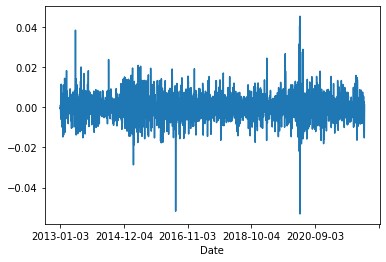

In [331]:
df2['NOK - £'].plot()